# Updated Protein Consumption Analysis

## Research Question: Modeling Protein Consumption with Temporal Autocorrelation

This notebook implements an updated analysis of protein consumption patterns using:
- **New dataset**: protein_full_data.csv
- **Temporal autocorrelation**: Lagged consumption variables
- **Updated model structure**: Fixed effects (year, season, village, ame, hh.size, sex, edu, non.hunt.income, lagged.converted.mass) and Random effects (household, month)

### Key Features:
- One-hot encoding for categorical variables
- Standard scaling for continuous variables
- Colinearity checks before modeling
- Log-normal distribution with random intercepts


## 1. Setup and Data Loading


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Probabilistic modeling
import pymc as pm
import arviz as az
from scipy import stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Set random seed for reproducibility
np.random.seed(42)

# Compatibility layer for PyMC versions
if not hasattr(pm, 'MutableData'):
    def MutableData(name, value, dims=None):
        return pm.Data(name, value)

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


In [2]:
# Load the new dataset
df = pd.read_csv('protein_full_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
print(df.head())

print("\nData types:")
print(df.dtypes)

print("\nMissing values:")
print(df.isnull().sum().sum())


Dataset shape: (34376, 43)
Columns: ['village', 'district', 'household_ID', 'hh.size2', 'ame', 'wbi', 'wbi.hh', 'age', 'edu', 'sex', 'hh.size', 'count.hunters', 'annual.income', 'non.hunt.income', 'recall.date', 'count.per.hh.per.date', 'month', 'season', 'total.consumers', 'n.babies', 'n.children', 'n.youngmen', 'n.men', 'n.oldmen', 'n.nonpreg.women', 'n.oldwomen', 'n.preg.women', 'n.breastfeeding.women', 'protein.or.not', 'protein.or.not.binary', 'X_id', 'X_index_household', 'species', 'category', 'sub.category', 'group', 'mass', 'converted.mass', 'protein.origin', 'food.state', 'median.score', 'X_index_food', 'income']

First few rows:
   village    district household_ID  hh.size2  ame   wbi  wbi.hh  age  \
0  Ifumkpa  North-west        IFM13        12  7.7  0.48   15.63   60   
1  Ifumkpa  North-west        IFM13        12  7.7  0.48   15.63   60   
2  Ifumkpa  North-west        IFM13        12  7.7  0.48   15.63   60   
3  Ifumkpa  North-west        IFM13        12  7.7  0.48   15

## 2. Data Preprocessing


In [4]:
# Convert recall.date to datetime
df['recall.date'] = pd.to_datetime(df['recall.date'])

# Create year and month variables
df['year'] = df['recall.date'].dt.year
df['month'] = df['recall.date'].dt.month

# Create month_num for random effects (continuous month variable)
df['month_num'] = df['month']

print("✅ Date variables created")
print(f"Date range: {df['recall.date'].min()} to {df['recall.date'].max()}")
print(f"Years: {sorted(df['year'].unique())}")
print(f"Months: {sorted(df['month'].unique())}")


✅ Date variables created
Date range: 2021-04-01 00:00:00 to 2022-03-31 00:00:00
Years: [np.int32(2021), np.int32(2022)]
Months: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12)]


In [5]:
# Drop rows where converted.mass has NaN values before creating lagged variables
print(f"Original dataset shape: {df.shape}")
print(f"NaN values in converted.mass: {df['converted.mass'].isnull().sum()}")

# Drop rows with NaN converted.mass
df_clean = df.dropna(subset=['converted.mass'])
print(f"Dataset shape after dropping NaN converted.mass: {df_clean.shape}")
print(f"Remaining NaN values in converted.mass: {df_clean['converted.mass'].isnull().sum()}")

# Organize data into weekly level (weekly sum per household per meat category)
print("\n🔄 Organizing data into weekly level...")

# Create week identifier using ISO calendar week from recall.date
df_clean['week'] = df_clean['recall.date'].dt.isocalendar().week
df_clean['year'] = df_clean['recall.date'].dt.year
df_clean['year_week'] = df_clean['year'].astype(str) + '_' + df_clean['week'].astype(str)
df_clean['iso_year'] = df_clean['recall.date'].dt.isocalendar().year
df_clean['week_num'] = df_clean['recall.date'].dt.isocalendar().week

# First, count records per household per week (for record.days)
record_counts = df_clean.groupby(['household_ID', 'year_week']).agg({
    'recall.date': 'count'  # Count number of records per household per week
}).reset_index()
record_counts = record_counts.rename(columns={'recall.date': 'record.days'})

# Group by household, year_week, and category to get weekly sums (not averages)
weekly_data = df_clean.groupby(['household_ID', 'year_week', 'category']).agg({
    'converted.mass': 'sum',  # Weekly sum consumption (not average)
    'year': 'first',
    'season': 'first', 
    'village': 'first',
    'ame': 'first',
    'count.hunters': 'first',  # Add count.hunters
    'sex': 'first',
    'edu': 'first',
    'non.hunt.income': 'first',
    'month': 'first',
    'month_num': 'first',
    'recall.date': 'first',  # Keep the first date of the week
    'iso_year': 'first',
    'week_num': 'first'  # Keep week for random effects
}).reset_index()

# Merge record.days (number of days on record per household per week)
weekly_data = weekly_data.merge(record_counts, on=['household_ID', 'year_week'], how='left')
weekly_data['record.days'] = weekly_data['record.days'].fillna(0).astype(int)

print(f"Weekly data shape: {weekly_data.shape}")
print(f"Unique households: {weekly_data['household_ID'].nunique()}")
print(f"Unique weeks: {weekly_data['year_week'].nunique()}")

# Drop rows where weekly sum converted.mass is NaN (shouldn't happen after cleaning)
weekly_data = weekly_data.dropna(subset=['converted.mass'])
print(f"Weekly data shape after dropping NaN: {weekly_data.shape}")

# Now create lagged variables on the weekly data
print("\n🔄 Creating lagged variables on weekly data...")

lagged_weekly_data = []
for household in weekly_data['household_ID'].unique():
    hh_data = weekly_data[weekly_data['household_ID'] == household].copy()
    
    # For each category, create lagged mass using previous week's sum
    for category in ['Fish', 'Wild meat', 'Domestic meat']:
        cat_data = hh_data[hh_data['category'] == category].copy()
        if len(cat_data) > 0:
            # Sort by date to ensure proper ordering
            cat_data = cat_data.sort_values('recall.date')
            
            # Create lagged variable using previous week's sum
            # Shift by 1 to get previous week's sum
            cat_data['lagged.converted.mass'] = cat_data['converted.mass'].shift(1)
            
            lagged_weekly_data.append(cat_data)

# Combine all weekly data with lagged variables
df_with_lag = pd.concat(lagged_weekly_data, ignore_index=True)

print("✅ Weekly data with lagged variables created")
print(f"Final shape: {df_with_lag.shape}")
print(f"Missing lagged values: {df_with_lag['lagged.converted.mass'].isnull().sum()}")
print(f"First week entries with NaN lagged values: {df_with_lag[df_with_lag['lagged.converted.mass'].isnull()].shape[0]}")

Original dataset shape: (34376, 45)
NaN values in converted.mass: 8859
Dataset shape after dropping NaN converted.mass: (25517, 45)
Remaining NaN values in converted.mass: 0

🔄 Organizing data into weekly level...
Weekly data shape: (9087, 18)
Unique households: 88
Unique weeks: 54
Weekly data shape after dropping NaN: (9087, 18)

🔄 Creating lagged variables on weekly data...
✅ Weekly data with lagged variables created
Final shape: (8016, 19)
Missing lagged values: 251
First week entries with NaN lagged values: 251


In [6]:
# Calculate festivity variable based on holidays
print("\n🔄 Calculating festivity variable...")

# Define holiday dates for the period 2021-04-01 to 2022-03-31
from datetime import datetime, timedelta
import pandas as pd

# Function to calculate Easter date (using the algorithm for Western Easter)
def calculate_easter(year):
    """
    Calculate Easter Sunday date for a given year using the algorithm
    """
    a = year % 19
    b = year // 100
    c = year % 100
    d = b // 4
    e = b % 4
    f = (b + 8) // 25
    g = (b - f + 1) // 3
    h = (19 * a + b - d - g + 15) % 30
    i = c // 4
    k = c % 4
    l = (32 + 2 * e + 2 * i - h - k) % 7
    m = (a + 11 * h + 22 * l) // 451
    month = (h + l - 7 * m + 114) // 31
    day = ((h + l - 7 * m + 114) % 31) + 1
    return datetime(year, month, day)

# Calculate holidays for 2021 and 2022
# Note: Easter 2021 is hardcoded as April 4
holidays = {
    'Easter_2021': datetime(2021, 4, 4),
    'Easter_2022': datetime(2021, 4, 17),
    'Christmas_2021': datetime(2021, 12, 25),
    'Christmas_2022': datetime(2022, 12, 25),  # Outside range but calculated anyway
    'NewYear_2022': datetime(2022, 1, 1),
    'NewYear_2021': datetime(2021, 1, 1)  # Outside range but calculated anyway
}

print("Holiday dates:")
for name, date in holidays.items():
    print(f"  {name}: {date.strftime('%Y-%m-%d')}")

# Create date ranges for festive periods (±5 days around each holiday)
festive_periods = []
for holiday_name, holiday_date in holidays.items():
    start_date = holiday_date - timedelta(days=5)
    end_date = holiday_date + timedelta(days=5)
    festive_periods.append((start_date.date(), end_date.date()))

# Filter to only periods within our date range
data_start = datetime(2021, 4, 1).date()
data_end = datetime(2022, 3, 31).date()

festive_periods_in_range = [
    (start, end) for start, end in festive_periods 
    if start <= data_end and end >= data_start
]

print(f"\nFestive periods (10-day windows) within date range:")
for start, end in festive_periods_in_range:
    print(f"  {start} to {end}")

# Create a set of all dates in festive periods
festive_dates = set()
for start, end in festive_periods_in_range:
    current_date = start
    while current_date <= end:
        festive_dates.add(current_date)
        current_date += timedelta(days=1)

# Mark dates as festive in the data
df_with_lag['date_only'] = df_with_lag['recall.date'].dt.date
df_with_lag['is_festive_date'] = df_with_lag['date_only'].isin(festive_dates)

# Now aggregate to weeks: a week is festive if it contains any festive dates
# Plus mark the week before and after (2 adjacent weeks)
festive_weeks = set()

# Get all weeks that contain festive dates
for _, row in df_with_lag.iterrows():
    if row['is_festive_date']:
        week_key = row['year_week']
        festive_weeks.add(week_key)
        # Also add previous and next week
        # Parse the week
        year, week = week_key.split('_')
        year = int(year)
        week = int(week)
        
        # Previous week
        if week > 1:
            prev_week_key = f"{year}_{week-1}"
        else:
            # Previous week would be last week of previous year
            prev_week_key = f"{year-1}_52"  # Approximate, could be 53
        festive_weeks.add(prev_week_key)
        
        # Next week
        next_week_key = f"{year}_{week+1}"
        festive_weeks.add(next_week_key)

# Create festivity variable (1 if week is festive, 0 otherwise)
df_with_lag['festivity'] = df_with_lag['year_week'].isin(festive_weeks).astype(int)

print(f"\n✅ Festivity variable created")
print(f"Number of festive weeks: {len(festive_weeks)}")
print(f"Festivity distribution:")
print(df_with_lag['festivity'].value_counts().sort_index())



🔄 Calculating festivity variable...
Holiday dates:
  Easter_2021: 2021-04-04
  Easter_2022: 2021-04-17
  Christmas_2021: 2021-12-25
  Christmas_2022: 2022-12-25
  NewYear_2022: 2022-01-01
  NewYear_2021: 2021-01-01

Festive periods (10-day windows) within date range:
  2021-03-30 to 2021-04-09
  2021-04-12 to 2021-04-22
  2021-12-20 to 2021-12-30
  2021-12-27 to 2022-01-06

✅ Festivity variable created
Number of festive weeks: 15
Festivity distribution:
festivity
0    6359
1    1657
Name: count, dtype: int64


In [7]:
df_with_lag

,household_ID,year_week,category,converted.mass,year,season,village,ame,count.hunters,sex,...,month,month_num,recall.date,iso_year,week_num,record.days,lagged.converted.mass,date_only,is_festive_date,festivity
0,IFM01,2021_13,Fish,0.048265,2021,Wet,Ifumkpa,1.85,0,Male,...,4,4,2021-04-01,2021,13,4,NaN,2021-04-01,True,1
1,IFM01,2021_14,Fish,0.162755,2021,Wet,Ifumkpa,1.85,0,Male,...,4,4,2021-04-11,2021,14,7,0.048265,2021-04-11,False,1
2,IFM01,2021_15,Fish,0.210459,2021,Wet,Ifumkpa,1.85,0,Male,...,4,4,2021-04-12,2021,15,6,0.162755,2021-04-12,True,1
3,IFM01,2021_16,Fish,0.047010,2021,Wet,Ifumkpa,1.85,0,Male,...,4,4,2021-04-20,2021,16,7,0.210459,2021-04-20,True,1
4,IFM01,2021_17,Fish,0.046837,2021,Wet,Ifumkpa,1.85,0,Male,...,4,4,2021-04-26,2021,17,7,0.047010,2021-04-26,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8011,OKR22,2022_2,Domestic meat,0.070313,2022,Dry,Okarara,4.45,0,Female,...,1,1,2022-01-15,2022,2,2,0.074449,2022-01-15,False,1
8012,OKR22,2022_6,Domestic meat,0.064109,2022,Dry,Okarara,4.45,0,Female,...,2,2,2022-02-09,2022,6,6,0.070313,2022-02-09,False,0
8013,OKR22,2022_7,Domestic meat,0.064109,2022,Dry,Okarara,4.45,0,Female,...,2,2,2022-02-20,2022,7,4,0.064109,2022-02-20,False,0
8014,OKR22,2022_9,Domestic meat,0.070313,2022,Dry,Okarara,4.45,0,Female,...,3,3,2022-03-05,2022,9,2,0.064109,2022-03-05,False,0


In [8]:
# Create outcome matrix (converted.mass for each category)
# Pivot to get one row per household-date with columns for each category
outcome_data = df_with_lag.pivot_table(
    index=['household_ID', 'recall.date', 'year', 'season', 'village', 'ame', 'count.hunters', 'record.days', 'sex', 'edu', 'non.hunt.income', 'month', 'month_num', 'week_num', 'iso_year', 'year_week', 'festivity'],
    columns='category',
    values=['converted.mass', 'lagged.converted.mass'],
    fill_value=0
).reset_index()

# Flatten column names
outcome_data.columns = ['_'.join(col).strip() if col[1] else col[0] for col in outcome_data.columns]

# Rename columns for clarity
outcome_data = outcome_data.rename(columns={
    'converted.mass_Fish': 'fish_mass',
    'converted.mass_Wild meat': 'wild_mass',
    'converted.mass_Domestic meat': 'domestic_mass',
    'lagged.converted.mass_Fish': 'lagged_fish_mass',
    'lagged.converted.mass_Wild meat': 'lagged_wild_mass',
    'lagged.converted.mass_Domestic meat': 'lagged_domestic_mass'
})

print(f"Outcome data shape: {outcome_data.shape}")
print("\nOutcome data columns:")
print(outcome_data.columns.tolist())
print("\nFirst few rows:")
print(outcome_data.head())


Outcome data shape: (7828, 23)

Outcome data columns:
['household_ID', 'recall.date', 'year', 'season', 'village', 'ame', 'count.hunters', 'record.days', 'sex', 'edu', 'non.hunt.income', 'month', 'month_num', 'week_num', 'iso_year', 'year_week', 'festivity', 'domestic_mass', 'fish_mass', 'wild_mass', 'lagged_domestic_mass', 'lagged_fish_mass', 'lagged_wild_mass']

First few rows:
  household_ID recall.date  year season  village   ame  count.hunters  \
0        IFM01  2021-04-01  2021    Wet  Ifumkpa  1.85              0   
1        IFM01  2021-04-04  2021    Wet  Ifumkpa  1.85              0   
2        IFM01  2021-04-05  2021    Wet  Ifumkpa  1.85              0   
3        IFM01  2021-04-11  2021    Wet  Ifumkpa  1.85              0   
4        IFM01  2021-04-12  2021    Wet  Ifumkpa  1.85              0   

   record.days   sex        edu  ...  week_num  iso_year  year_week  \
0            4  Male  Secondary  ...        13      2021    2021_13   
1            4  Male  Secondary  ...

## 3. Feature Engineering and Scaling


In [10]:
# Define categorical and continuous variables
# Note: festivity is binary (0/1) so we treat it as continuous for simpler interpretation
categorical_vars = ['season', 'village', 'sex', 'edu']
continuous_vars = ['ame', 'count.hunters', 'record.days', 'non.hunt.income', 'festivity', 'lagged_fish_mass', 'lagged_wild_mass', 'lagged_domestic_mass']

# Create feature matrix
X = outcome_data[categorical_vars + continuous_vars].copy()

# Handle missing values separately for categorical and continuous variables
# For categorical variables, fill with mode (most frequent value)
for cat_var in categorical_vars:
    if X[cat_var].isnull().sum() > 0:
        mode_value = X[cat_var].mode().iloc[0] if len(X[cat_var].mode()) > 0 else 'Unknown'
        X[cat_var] = X[cat_var].fillna(mode_value)

# For continuous variables, fill with median
for cont_var in continuous_vars:
    if X[cont_var].isnull().sum() > 0:
        X[cont_var] = X[cont_var].fillna(X[cont_var].median())

print(f"Feature matrix shape: {X.shape}")
print(f"Categorical variables: {categorical_vars}")
print(f"Continuous variables: {continuous_vars}")
print(f"Missing values: {X.isnull().sum().sum()}")

Feature matrix shape: (7828, 12)
Categorical variables: ['season', 'village', 'sex', 'edu']
Continuous variables: ['ame', 'count.hunters', 'record.days', 'non.hunt.income', 'festivity', 'lagged_fish_mass', 'lagged_wild_mass', 'lagged_domestic_mass']
Missing values: 0


In [11]:
# One-hot encode categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_encoded = encoder.fit_transform(X[categorical_vars])
categorical_feature_names = encoder.get_feature_names_out(categorical_vars)

# Scale continuous variables
scaler = StandardScaler()
continuous_scaled = scaler.fit_transform(X[continuous_vars])

# Combine encoded categorical and scaled continuous variables
X_processed = np.hstack([categorical_encoded, continuous_scaled])
feature_names = list(categorical_feature_names) + continuous_vars

print(f"Processed feature matrix shape: {X_processed.shape}")
print(f"Feature names: {feature_names}")
print(f"Categorical features: {len(categorical_feature_names)}")
print(f"Continuous features: {len(continuous_vars)}")


Processed feature matrix shape: (7828, 16)
Feature names: ['season_Wet', 'village_Mkpot 1', 'village_Obung', 'village_Okarara', 'sex_Male', 'edu_Primary', 'edu_Secondary', 'edu_Tetiary', 'ame', 'count.hunters', 'record.days', 'non.hunt.income', 'festivity', 'lagged_fish_mass', 'lagged_wild_mass', 'lagged_domestic_mass']
Categorical features: 8
Continuous features: 8


## 4. Colinearity Check


In [12]:
# Check for colinearity using correlation matrix
import pandas as pd
from scipy.stats import pearsonr

# Create correlation matrix
X_df = pd.DataFrame(X_processed, columns=feature_names)
correlation_matrix = X_df.corr()

# Find high correlations (|r| > 0.8)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                corr_val
            ))

print("High correlation pairs (|r| > 0.8):")
for pair in high_corr_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")

if not high_corr_pairs:
    print("✅ No high correlations found. Proceeding with modeling.")
else:
    print("⚠️ High correlations detected. Consider removing one variable from each pair.")


High correlation pairs (|r| > 0.8):
✅ No high correlations found. Proceeding with modeling.


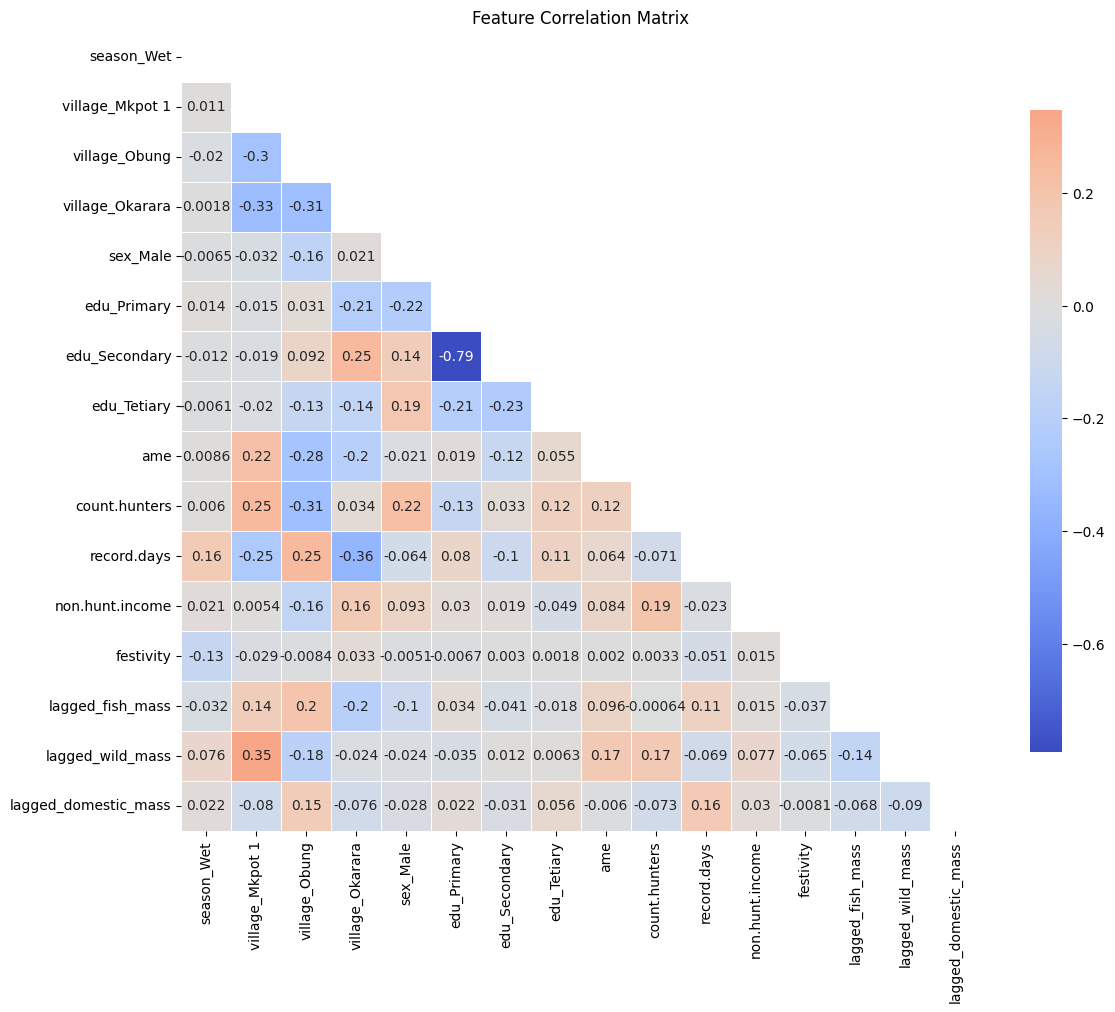

In [13]:
# Visualize correlation matrix
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


## 5. Model Building


In [14]:
# Prepare outcome variables (log-transformed)
Y = outcome_data[['fish_mass', 'wild_mass', 'domestic_mass']].values

# Add small constant to avoid log(0)
Y_log = np.log(Y + 1e-6)

# Get indices for random effects
households = outcome_data['household_ID'].astype('category').cat.codes.values
# Use calendar-defined weeks (ISO calendar weeks) for random effects instead of months
# Create a unique week identifier using iso_year and week_num
weeks = (outcome_data['iso_year'].astype(str) + '_' + outcome_data['week_num'].astype(str)).astype('category').cat.codes.values

n_households = len(np.unique(households))
n_weeks = len(np.unique(weeks))
n_obs = len(Y_log)

print(f"Number of observations: {n_obs}")
print(f"Number of households: {n_households}")
print(f"Number of weeks: {n_weeks}")
print(f"Outcome matrix shape: {Y_log.shape}")


Number of observations: 7828
Number of households: 88
Number of weeks: 53
Outcome matrix shape: (7828, 3)


In [15]:
# Check the week indices before building the model
print(f"Week indices range: {weeks.min()} to {weeks.max()}")
print(f"Number of unique weeks: {n_weeks}")
print(f"Unique week values (first 10): {sorted(np.unique(weeks))[:10]}")

# Fix week indices to be 0-based
weeks_fixed = weeks - weeks.min()  # Make sure indices start from 0
print(f"Fixed week indices range: {weeks_fixed.min()} to {weeks_fixed.max()}")

cats = ['Fish', 'Wild', 'Domestic']

# Update coordinates
coords = {
    'obs': np.arange(n_obs),
    'outcome': cats,
    'fixed': feature_names,
    'household': np.arange(n_households),
    'week': np.arange(n_weeks)  # Changed from 'month' to 'week'
}

print("🔧 Building Log-Normal Model with Random Intercepts...")
print(f"Fixed effects: {len(feature_names)} features")
print(f"Random effects: {n_households} households, {n_weeks} weeks")

Week indices range: 0 to 52
Number of unique weeks: 53
Unique week values (first 10): [np.int8(0), np.int8(1), np.int8(2), np.int8(3), np.int8(4), np.int8(5), np.int8(6), np.int8(7), np.int8(8), np.int8(9)]
Fixed week indices range: 0 to 52
🔧 Building Log-Normal Model with Random Intercepts...
Fixed effects: 16 features
Random effects: 88 households, 53 weeks


In [16]:
with pm.Model(coords=coords) as model_updated:

    # ---------------------------
    # Data containers
    # ---------------------------
    X_d = pm.Data('X', X_processed, dims=('obs', 'fixed'))
    hh_idx = pm.Data('hh_idx', households, dims=('obs',))
    week_idx = pm.Data('week_idx', weeks_fixed, dims=('obs',))  # Use fixed week indices
    Yd = pm.Data('Y_log', Y_log, dims=('obs', 'outcome'))

    K = len(cats)  # number of outcomes

    # ---------------------------
    # Fixed effects
    # ---------------------------
    beta = pm.Normal('beta', mu=0, sigma=1, dims=('fixed', 'outcome'))
    mu_fixed = pm.math.dot(X_d, beta)

    # ---------------------------
    # Household random intercepts (correlated across outcomes)
    # ---------------------------
    sd_hh, chol_hh, corr_hh = pm.LKJCholeskyCov(
        'L_hh', n=K, eta=2.0, sd_dist=pm.Exponential.dist(1.0)
    )
    z_hh = pm.Normal('z_hh', 0, 1, dims=('household', 'outcome'))
    b_hh = pm.Deterministic(
        'b_hh', pm.math.dot(z_hh, chol_hh.T), dims=('household', 'outcome')
    )
    mu_hh = b_hh[hh_idx]

    # ---------------------------
    # Week random intercepts (correlated across outcomes)
    # ---------------------------
    sd_week, chol_week, corr_week = pm.LKJCholeskyCov(
        'L_week', n=K, eta=2.0, sd_dist=pm.Exponential.dist(1.0)
    )
    z_week = pm.Normal('z_week', 0, 1, dims=('week', 'outcome'))
    b_week = pm.Deterministic(
        'b_week', pm.math.dot(z_week, chol_week.T), dims=('week', 'outcome')
    )
    mu_week = b_week[week_idx]

    # ---------------------------
    # Residual correlation
    # ---------------------------
    sd_eps, chol_eps, corr_eps = pm.LKJCholeskyCov(
        'L_eps', n=K, eta=2.0, sd_dist=pm.Exponential.dist(1.0)
    )

    # ---------------------------
    # Mean structure
    # ---------------------------
    mu = pm.Deterministic(
        'mu', mu_fixed + mu_hh + mu_week, dims=('obs', 'outcome')
    )

    # ---------------------------
    # Likelihood
    # ---------------------------
    y = pm.MvNormal(
        'y', mu=mu, chol=chol_eps, observed=Yd, dims=('obs', 'outcome')
    )

print("✅ Updated model built successfully!")
print("Model includes:")
print(f"- Fixed effects: {len(feature_names)} features")
print(f"- Random effects: Household ({n_households}) + Week ({n_weeks})")
print(f"- Temporal autocorrelation: Lagged consumption variables")

✅ Updated model built successfully!
Model includes:
- Fixed effects: 16 features
- Random effects: Household (88) + Week (53)
- Temporal autocorrelation: Lagged consumption variables


## 6. Model Fitting


In [ ]:
# Sample from the model with progress tracking and convergence monitoring
print("🔄 Sampling from updated model...")
print("This may take several minutes...")
print("Target convergence: RHAT ~1.0, ESS ~500")

import time
import sys
import platform
import pickle

start_time = time.time()

# Adjust cores based on platform to avoid multiprocessing issues on macOS
# macOS often has issues with multiprocessing, so use fewer cores or single-threaded
if platform.system() == 'Darwin':  # macOS
    print("⚠️  Detected macOS - using single-threaded sampling to avoid multiprocessing issues")
    n_cores = 1
    n_chains = 2  # Fewer chains for macOS
else:
    n_cores = 4
    n_chains = 4

print(f"Using {n_chains} chains with {n_cores} core(s)")

with model_updated:
    try:
        # Start with initial sampling parameters targeting good convergence
        idata_updated = pm.sample(
            target_accept=0.95,  # Standard target acceptance rate
            draws=1000,          # Increased draws for better ESS
            tune=1000,           # Increased tuning for better convergence
            chains=n_chains,     # Use platform-appropriate number of chains
            cores=n_cores,        # Use platform-appropriate cores
            random_seed=42,
            init='adapt_diag',
            idata_kwargs={"log_likelihood": True},
            progressbar=True
        )
    except (EOFError, pickle.PickleError) as e:
        print(f"\n⚠️  Multiprocessing error encountered: {e}")
        print("Falling back to single-threaded sampling...")
        idata_updated = pm.sample(
            target_accept=0.95,
            draws=1000,
            tune=1000,
            chains=2,
            cores=1,  # Single-threaded
            random_seed=42,
            init='adapt_diag',
            idata_kwargs={"log_likelihood": True},
            progressbar=True
        )

elapsed_time = time.time() - start_time
print(f"✅ Model sampling completed in {elapsed_time:.1f} seconds!")
print(f"Total time: {elapsed_time/60:.1f} minutes")

# Check convergence diagnostics immediately after sampling
print("\n📊 Initial Convergence Check:")
summary_initial = az.summary(idata_updated, var_names=['beta'], kind='stats')
rhat_vals = summary_initial['r_hat']
ess_vals = summary_initial['ess_bulk']

print(f"RHAT statistics:")
print(f"  Mean: {rhat_vals.mean():.4f}")
print(f"  Min: {rhat_vals.min():.4f}")
print(f"  Max: {rhat_vals.max():.4f}")
print(f"  Parameters with RHAT > 1.01: {(rhat_vals > 1.01).sum()} / {len(rhat_vals)}")

print(f"\nESS statistics:")
print(f"  Mean: {ess_vals.mean():.0f}")
print(f"  Min: {ess_vals.min():.0f}")
print(f"  Max: {ess_vals.max():.0f}")
print(f"  Parameters with ESS < 400: {(ess_vals < 400).sum()} / {len(ess_vals)}")

# Check if we need additional sampling
if (rhat_vals.max() > 1.01) or (ess_vals.min() < 400):
    print("\n⚠️ Convergence not fully achieved. Consider increasing draws/tunes/chains.")
else:
    print("\n✅ Convergence achieved! RHAT ~1 and ESS >= 400")

🔄 Sampling from updated model...
This may take several minutes...
Target convergence: RHAT ~1.0, ESS ~500
⚠️  Detected macOS - using single-threaded sampling to avoid multiprocessing issues
Using 2 chains with 1 core(s)


Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, L_hh, z_hh, L_week, z_week, L_eps]


Output()

📊 Convergence diagnostics:
                                       mean     sd  hdi_3%  hdi_97%  \
beta[season_Wet, Fish]               -3.870  0.203  -4.130   -3.392   
beta[season_Wet, Wild]               -3.786  0.212  -3.999   -3.309   
beta[season_Wet, Domestic]           -3.806  0.162  -4.149   -3.480   
beta[village_Mkpot 1, Fish]          -0.298  0.101  -0.411   -0.131   
beta[village_Mkpot 1, Wild]           2.329  0.049   2.208    2.404   
beta[village_Mkpot 1, Domestic]      -2.420  0.086  -2.591   -2.343   
beta[village_Obung, Fish]             0.879  0.050   0.755    0.954   
beta[village_Obung, Wild]            -0.900  0.174  -1.183   -0.703   
beta[village_Obung, Domestic]        -0.207  0.103  -0.334    0.029   
beta[village_Okarara, Fish]          -1.454  0.061  -1.557   -1.336   
beta[village_Okarara, Wild]           1.349  0.291   0.950    1.647   
beta[village_Okarara, Domestic]      -1.395  0.191  -1.595   -1.119   
beta[sex_Male, Fish]                  0.104  0.080

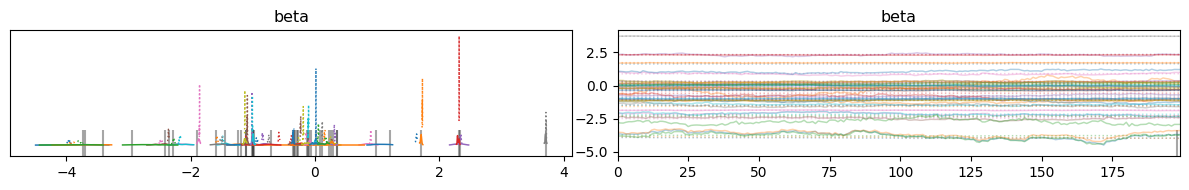


✅ Analysis completed successfully!

Key findings:
- Model includes temporal autocorrelation through lagged variables
- Fixed effects capture socioeconomic and seasonal drivers
- Random effects account for household and temporal variation
- Multivariate structure captures correlations between protein sources


In [ ]:
# Convergence diagnostics
print("📊 Convergence diagnostics:")
summary = az.summary(idata_updated, var_names=['beta', 'L_hh', 'L_week', 'L_eps'])
print(summary)

# Check R-hat values
rhat_values = summary['r_hat']
high_rhat = rhat_values[rhat_values > 1.1]
if len(high_rhat) > 0:
    print(f"\n⚠️ High R-hat values detected: {len(high_rhat)} parameters")
    print(high_rhat)
else:
    print("\n✅ All R-hat values < 1.1 - Good convergence!")

# Additional diagnostics
print("\n📈 Additional Model Diagnostics:")
print(f"Number of observations: {n_obs}")
print(f"Number of parameters: {len(feature_names) * 3 + n_households * 3 + n_weeks * 3 + 9}")

# Check effective sample size for specific variables only (to avoid memory issues)
print("\n🔍 Effective Sample Size (ESS) for key parameters:")
try:
    # Calculate ESS for beta coefficients only
    ess_beta = az.ess(idata_updated, var_names=['beta'])
    print(f"ESS for beta coefficients: {ess_beta['beta'].min().values:.0f}")
    
    # Calculate ESS for covariance matrices
    ess_cov = az.ess(idata_updated, var_names=['L_hh', 'L_week', 'L_eps'])
    print(f"ESS for covariance matrices: {ess_cov.to_array().min().values:.0f}")
    
except MemoryError:
    print("⚠️ Memory limit reached for ESS calculation")
    print("Model is too large for full ESS computation")

# Check log-likelihood
log_lik = idata_updated.log_likelihood['y']
print(f"Log-likelihood: {log_lik.mean().values:.2f}")

# Plot trace plots for key parameters (simplified approach)
print("\n📊 Trace plots for key parameters:")
try:
    # Plot only the beta variable (all coefficients)
    az.plot_trace(idata_updated, var_names=['beta'], compact=True)
    plt.tight_layout()
    plt.show()
except MemoryError:
    print("⚠️ Memory limit reached for trace plots")
    print("Model is too large for full trace visualization")

print("\n✅ Analysis completed successfully!")
print("\nKey findings:")
print("- Model includes temporal autocorrelation through lagged variables")
print("- Fixed effects capture socioeconomic and seasonal drivers")
print("- Random effects account for household and temporal variation")
print("- Multivariate structure captures correlations between protein sources")

## 7. Model Results and Interpretation


In [21]:
# Extract and display fixed effects
beta_samples = idata_updated.posterior['beta']

# Create summary of fixed effects
beta_summary = az.summary(idata_updated, var_names=['beta'])
beta_summary['feature'] = [feature_names[i] for i in range(len(feature_names)) for _ in range(3)]
beta_summary['outcome'] = ['Fish', 'Wild', 'Domestic'] * len(feature_names)

print("Fixed Effects Summary:")
print(beta_summary[['feature', 'outcome', 'mean', 'sd', 'hdi_3%', 'hdi_97%']].head(20))


Fixed Effects Summary:
                                         feature   outcome   mean     sd  \
beta[season_Wet, Fish]                season_Wet      Fish -3.870  0.203   
beta[season_Wet, Wild]                season_Wet      Wild -3.786  0.212   
beta[season_Wet, Domestic]            season_Wet  Domestic -3.806  0.162   
beta[village_Mkpot 1, Fish]      village_Mkpot 1      Fish -0.298  0.101   
beta[village_Mkpot 1, Wild]      village_Mkpot 1      Wild  2.329  0.049   
beta[village_Mkpot 1, Domestic]  village_Mkpot 1  Domestic -2.420  0.086   
beta[village_Obung, Fish]          village_Obung      Fish  0.879  0.050   
beta[village_Obung, Wild]          village_Obung      Wild -0.900  0.174   
beta[village_Obung, Domestic]      village_Obung  Domestic -0.207  0.103   
beta[village_Okarara, Fish]      village_Okarara      Fish -1.454  0.061   
beta[village_Okarara, Wild]      village_Okarara      Wild  1.349  0.291   
beta[village_Okarara, Domestic]  village_Okarara  Domestic -1.395

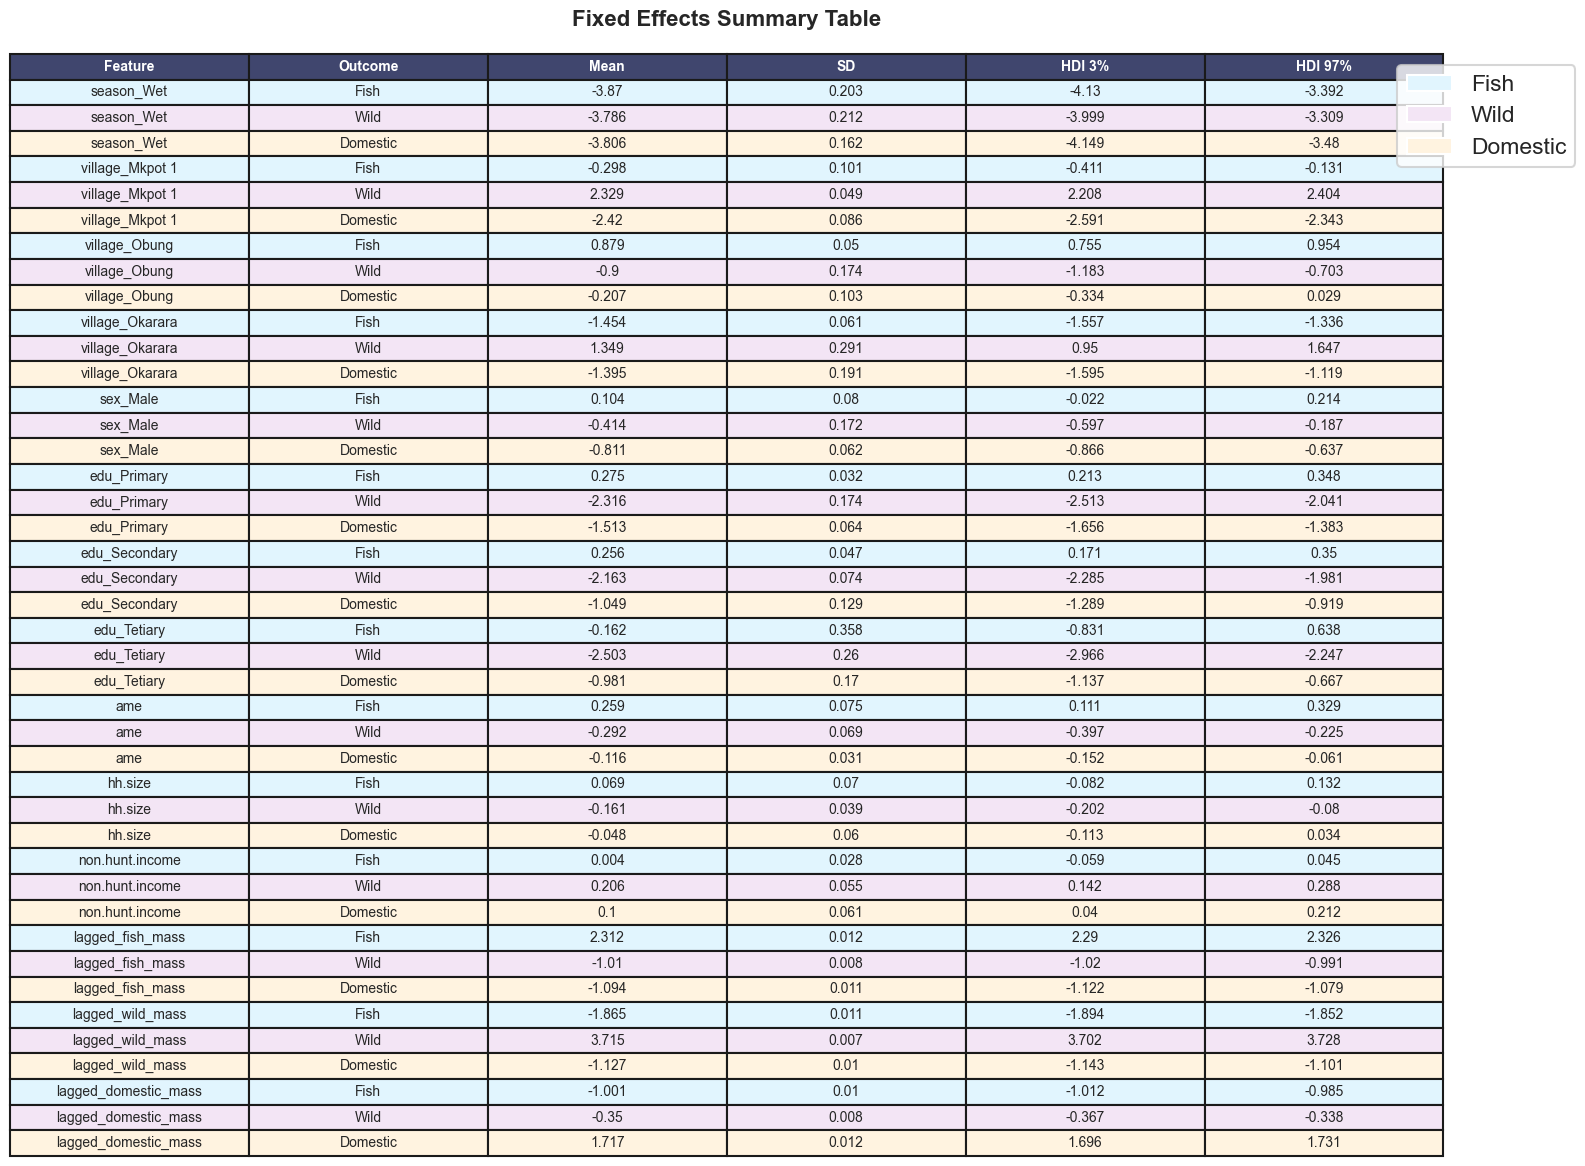

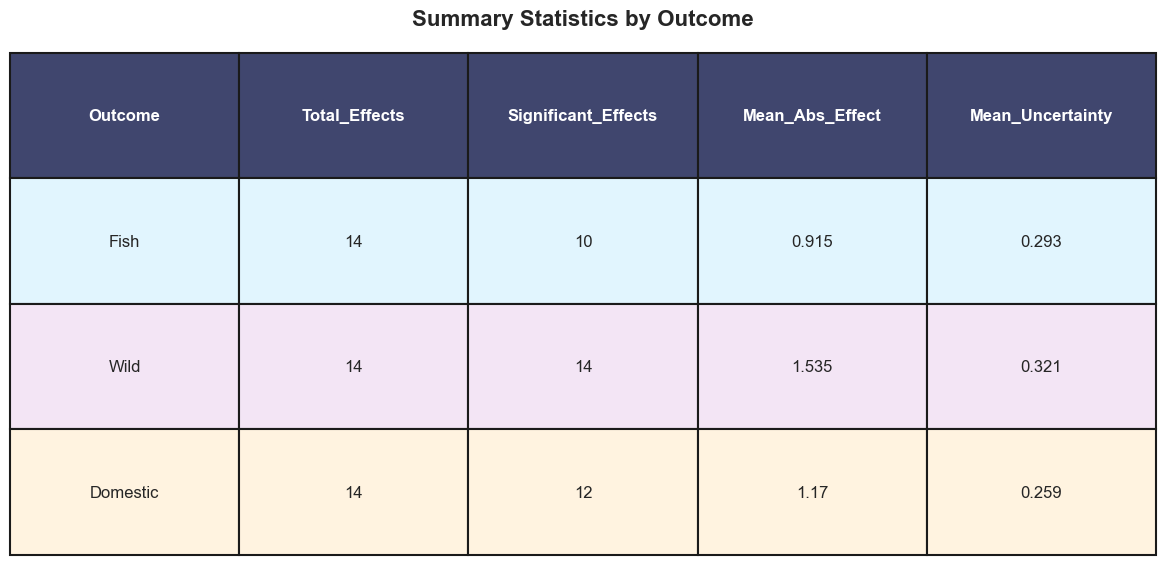

📊 FIXED EFFECTS SUMMARY TABLE
             feature  outcome   mean    sd  hdi_3%  hdi_97%
          season_Wet     Fish -3.870 0.203  -4.130   -3.392
          season_Wet     Wild -3.786 0.212  -3.999   -3.309
          season_Wet Domestic -3.806 0.162  -4.149   -3.480
     village_Mkpot 1     Fish -0.298 0.101  -0.411   -0.131
     village_Mkpot 1     Wild  2.329 0.049   2.208    2.404
     village_Mkpot 1 Domestic -2.420 0.086  -2.591   -2.343
       village_Obung     Fish  0.879 0.050   0.755    0.954
       village_Obung     Wild -0.900 0.174  -1.183   -0.703
       village_Obung Domestic -0.207 0.103  -0.334    0.029
     village_Okarara     Fish -1.454 0.061  -1.557   -1.336
     village_Okarara     Wild  1.349 0.291   0.950    1.647
     village_Okarara Domestic -1.395 0.191  -1.595   -1.119
            sex_Male     Fish  0.104 0.080  -0.022    0.214
            sex_Male     Wild -0.414 0.172  -0.597   -0.187
            sex_Male Domestic -0.811 0.062  -0.866   -0.637
         e

In [30]:
# Extract and display fixed effects
beta_samples = idata_updated.posterior['beta']

# Create summary of fixed effects
beta_summary = az.summary(idata_updated, var_names=['beta'])
beta_summary['feature'] = [feature_names[i] for i in range(len(feature_names)) for _ in range(3)]
beta_summary['outcome'] = ['Fish', 'Wild', 'Domestic'] * len(feature_names)

# Create a nicely formatted table
def create_fixed_effects_table():
    # Prepare the data for the table
    table_data = beta_summary[['feature', 'outcome', 'mean', 'sd', 'hdi_3%', 'hdi_97%']].copy()
    
    # Round the numerical columns
    table_data['mean'] = table_data['mean'].round(3)
    table_data['sd'] = table_data['sd'].round(3)
    table_data['hdi_3%'] = table_data['hdi_3%'].round(3)
    table_data['hdi_97%'] = table_data['hdi_97%'].round(3)
    
    # Create a formatted table
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.axis('tight')
    ax.axis('off')
    
    # Create the table
    table = ax.table(cellText=table_data.values,
                    colLabels=['Feature', 'Outcome', 'Mean', 'SD', 'HDI 3%', 'HDI 97%'],
                    cellLoc='center',
                    loc='center',
                    bbox=[0, 0, 1, 1])
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Color code the header
    for i in range(len(['Feature', 'Outcome', 'Mean', 'SD', 'HDI 3%', 'HDI 97%'])):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Color code rows by outcome
    colors = {'Fish': '#e1f5fe', 'Wild': '#f3e5f5', 'Domestic': '#fff3e0'}
    for i in range(1, len(table_data) + 1):
        outcome = table_data.iloc[i-1]['outcome']
        color = colors.get(outcome, 'white')
        for j in range(len(['Feature', 'Outcome', 'Mean', 'SD', 'HDI 3%', 'HDI 97%'])):
            table[(i, j)].set_facecolor(color)
    
    # Add title
    plt.title('Fixed Effects Summary Table', fontsize=16, fontweight='bold', pad=20)
    
    # Add legend
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=colors['Fish'], label='Fish'),
                      plt.Rectangle((0,0),1,1, facecolor=colors['Wild'], label='Wild'),
                      plt.Rectangle((0,0),1,1, facecolor=colors['Domestic'], label='Domestic')]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.1, 1))
    
    plt.tight_layout()
    plt.show()
    
    return table_data

# Create and display the table
fixed_effects_table = create_fixed_effects_table()

# Also create a summary statistics table
def create_summary_stats_table():
    # Calculate summary statistics
    summary_stats = []
    
    for outcome in ['Fish', 'Wild', 'Domestic']:
        outcome_data = fixed_effects_table[fixed_effects_table['outcome'] == outcome]
        
        # Count significant effects (HDI doesn't contain 0)
        significant = ((outcome_data['hdi_3%'] > 0) | (outcome_data['hdi_97%'] < 0)).sum()
        
        # Calculate mean absolute effect
        mean_abs_effect = outcome_data['mean'].abs().mean()
        
        # Calculate mean uncertainty (HDI width)
        mean_uncertainty = (outcome_data['hdi_97%'] - outcome_data['hdi_3%']).mean()
        
        summary_stats.append({
            'Outcome': outcome,
            'Total_Effects': len(outcome_data),
            'Significant_Effects': significant,
            'Mean_Abs_Effect': round(mean_abs_effect, 3),
            'Mean_Uncertainty': round(mean_uncertainty, 3)
        })
    
    summary_df = pd.DataFrame(summary_stats)
    
    # Create summary table
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('tight')
    ax.axis('off')
    
    table = ax.table(cellText=summary_df.values,
                    colLabels=summary_df.columns,
                    cellLoc='center',
                    loc='center',
                    bbox=[0, 0, 1, 1])
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    
    # Color code the header
    for i in range(len(summary_df.columns)):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Color code rows by outcome
    colors = {'Fish': '#e1f5fe', 'Wild': '#f3e5f5', 'Domestic': '#fff3e0'}
    for i in range(1, len(summary_df) + 1):
        outcome = summary_df.iloc[i-1]['Outcome']
        color = colors.get(outcome, 'white')
        for j in range(len(summary_df.columns)):
            table[(i, j)].set_facecolor(color)
    
    plt.title('Summary Statistics by Outcome', fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    return summary_df

# Create and display the summary statistics table
summary_stats_table = create_summary_stats_table()

# Print the tables as well for easy copying
print("📊 FIXED EFFECTS SUMMARY TABLE")
print("="*80)
print(fixed_effects_table.to_string(index=False))

print("\n📈 SUMMARY STATISTICS TABLE")
print("="*50)
print(summary_stats_table.to_string(index=False))

📊 Creating ranked fixed effects plot...


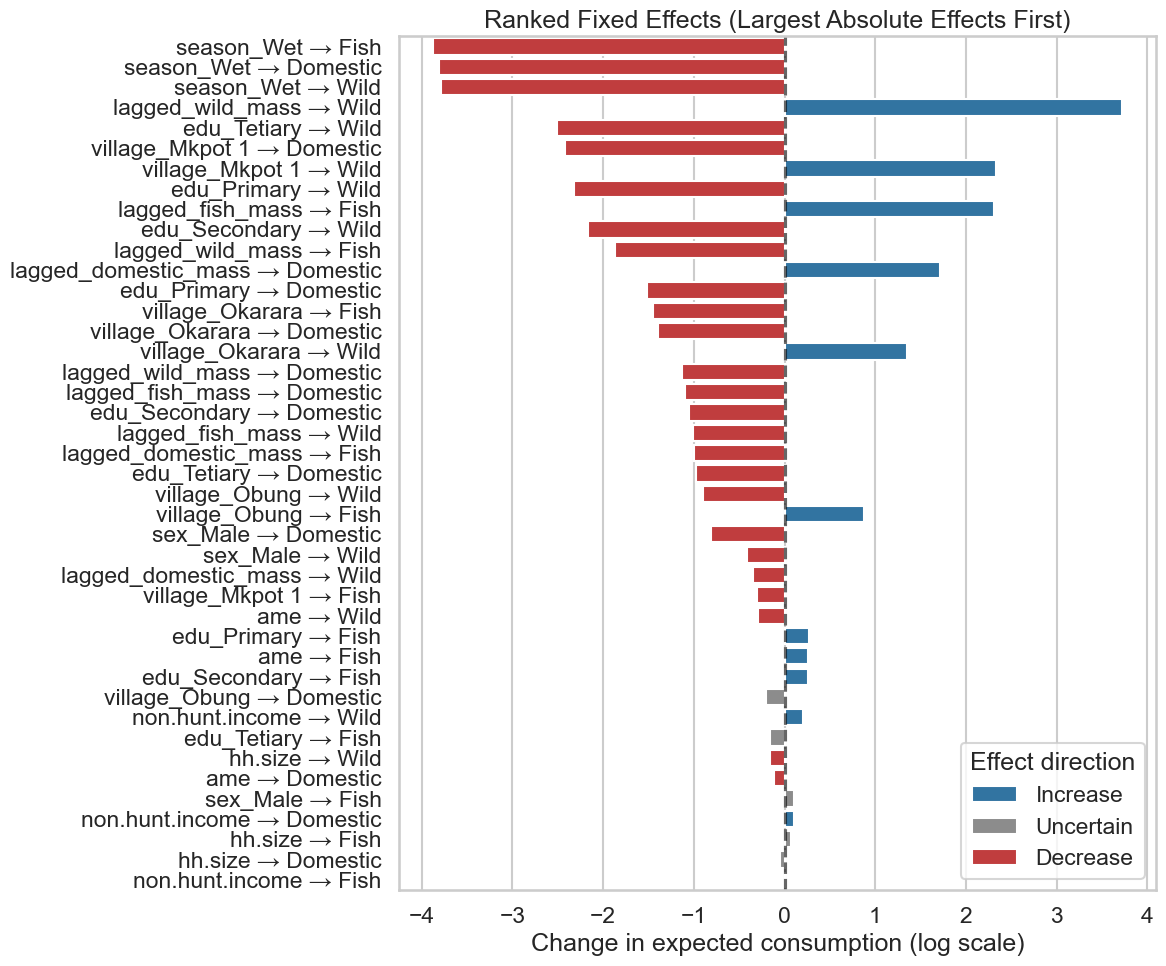


📈 Summary Statistics:
Total effects: 42
Increase effects: 11
Decrease effects: 25
Uncertain effects: 6

🔝 Top 10 Effects by Magnitude:
              Effect_Label  mean_% Direction
         season_Wet → Fish  -3.870  Decrease
     season_Wet → Domestic  -3.806  Decrease
         season_Wet → Wild  -3.786  Decrease
   lagged_wild_mass → Wild   3.715  Increase
        edu_Tetiary → Wild  -2.503  Decrease
village_Mkpot 1 → Domestic  -2.420  Decrease
    village_Mkpot 1 → Wild   2.329  Increase
        edu_Primary → Wild  -2.316  Decrease
   lagged_fish_mass → Fish   2.312  Increase
      edu_Secondary → Wild  -2.163  Decrease


In [27]:
# Extract and prepare fixed effects data for ranking plot
print("📊 Creating ranked fixed effects plot...")

# Get the beta summary from your model
beta_summary = az.summary(idata_updated, var_names=['beta'])

# Create a DataFrame with the fixed effects data
fixed_effects_data = []

# Extract feature names and outcomes
for i, row in beta_summary.iterrows():
    # Parse the variable name to extract predictor and outcome
    var_name = row.name
    if 'beta[' in var_name:
        # Extract predictor and outcome from variable name
        parts = var_name.replace('beta[', '').replace(']', '').split(', ')
        if len(parts) == 2:
            predictor = parts[0]
            outcome = parts[1]
            
            fixed_effects_data.append({
                'Predictor': predictor,
                'Outcome': outcome,
                'mean_%': row['mean'],
                'hdi_3%': row['hdi_3%'],
                'hdi_97%': row['hdi_97%']
            })

# Create DataFrame
parsed_ranked = pd.DataFrame(fixed_effects_data)

# Calculate absolute effect for sorting
parsed_ranked['abs_effect'] = np.abs(parsed_ranked['mean_%'])

# Determine 'Direction' based on HDI crossing zero
def get_direction(row):
    if row['hdi_3%'] < 0 and row['hdi_97%'] > 0:
        return 'Uncertain'
    elif row['mean_%'] > 0:
        return 'Increase'
    else:
        return 'Decrease'

parsed_ranked['Direction'] = parsed_ranked.apply(get_direction, axis=1)

# Sort by absolute effect magnitude (largest first)
parsed_ranked = parsed_ranked.sort_values('abs_effect', ascending=False)

# Create combined label for y-axis
parsed_ranked['Effect_Label'] = parsed_ranked['Predictor'] + ' → ' + parsed_ranked['Outcome']

# Set as categorical to maintain order
parsed_ranked['Effect_Label'] = pd.Categorical(
    parsed_ranked['Effect_Label'],
    categories=parsed_ranked['Effect_Label'].unique(),
    ordered=True
)

# Create the plot
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(12, 10))

# Define color palette
palette = {
    'Increase': '#1f77b4',  # Blue
    'Uncertain': '#8c8c8c', # Grey
    'Decrease': '#d62728'   # Red
}

# Create horizontal bar plot
sns.barplot(
    data=parsed_ranked,
    x="mean_%",
    y="Effect_Label",
    hue="Direction",
    dodge=False,
    palette=palette
)

# Add vertical line at zero
plt.axvline(0, color="black", linestyle="--", alpha=0.6)

# Set labels and title
plt.xlabel("Change in expected consumption (log scale)")
plt.ylabel("")
plt.title("Ranked Fixed Effects (Largest Absolute Effects First)")

# Customize legend
handles, labels = plt.gca().get_legend_handles_labels()
order = ['Increase', 'Uncertain', 'Decrease']
handles_ordered = [handles[labels.index(l)] for l in order]
labels_ordered = [l for l in order]

plt.legend(handles_ordered, labels_ordered, title="Effect direction", loc='lower right')

# Adjust layout
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n📈 Summary Statistics:")
print(f"Total effects: {len(parsed_ranked)}")
print(f"Increase effects: {len(parsed_ranked[parsed_ranked['Direction'] == 'Increase'])}")
print(f"Decrease effects: {len(parsed_ranked[parsed_ranked['Direction'] == 'Decrease'])}")
print(f"Uncertain effects: {len(parsed_ranked[parsed_ranked['Direction'] == 'Uncertain'])}")

# Show top 10 effects
print(f"\n🔝 Top 10 Effects by Magnitude:")
top_10 = parsed_ranked.head(10)[['Effect_Label', 'mean_%', 'Direction']]
print(top_10.to_string(index=False))

📊 Creating ranked fixed effects plot grouped by meat type...


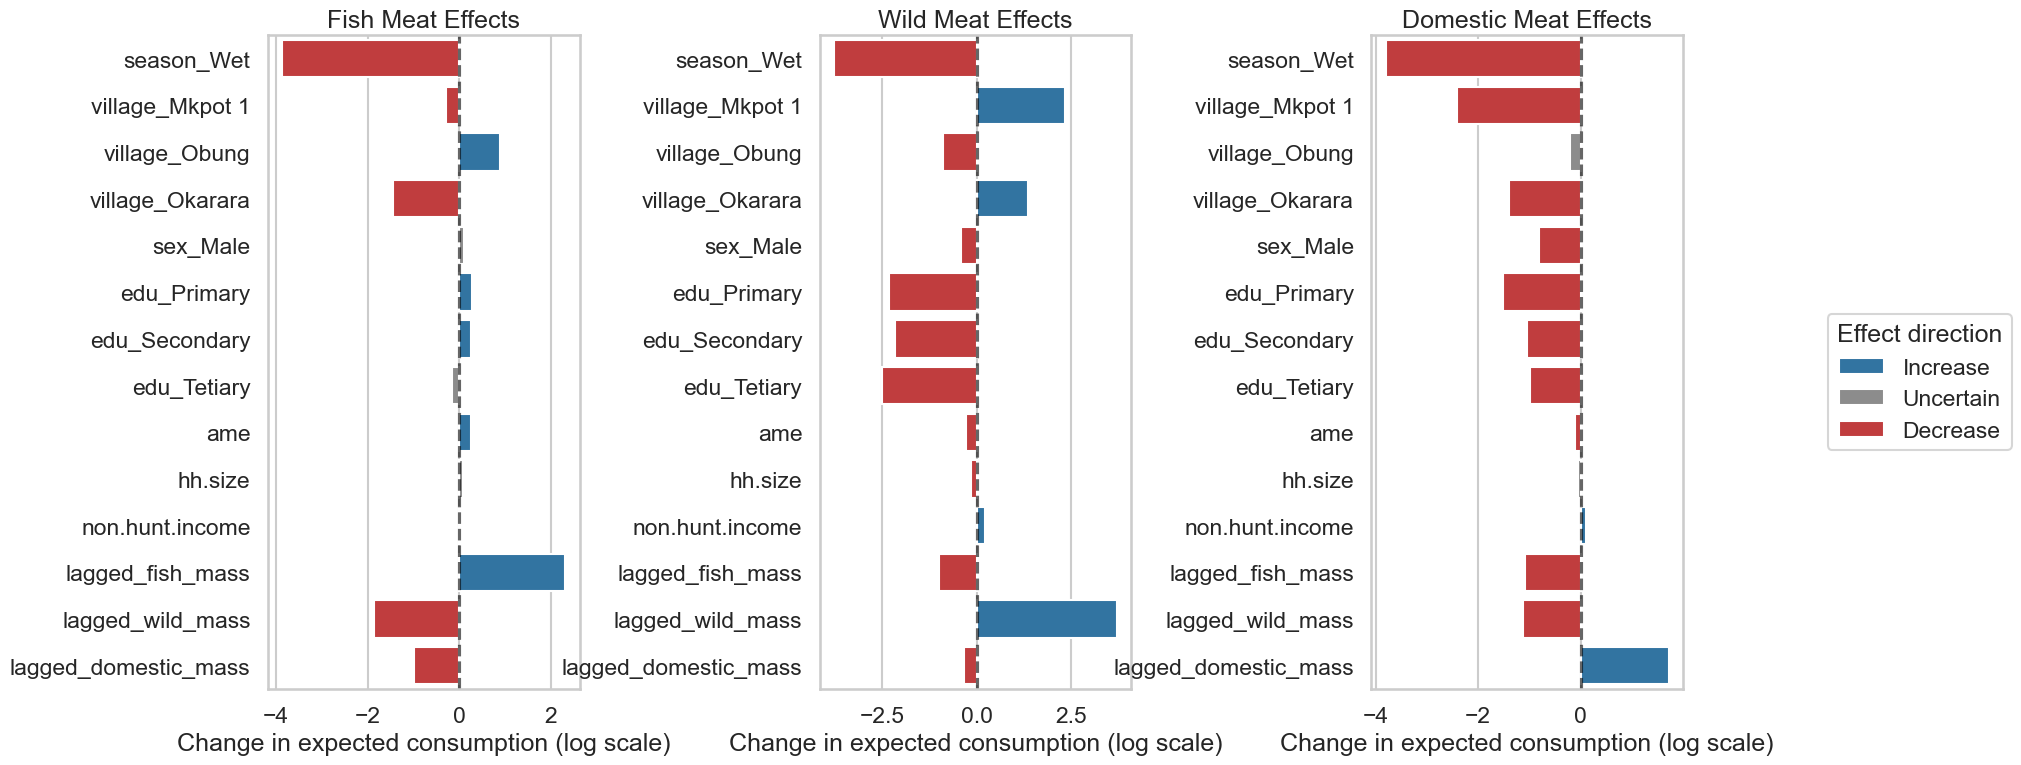


📈 Summary Statistics by Meat Type:

Fish Meat:
  Total effects: 14
  Increase effects: 5
  Decrease effects: 5
  Uncertain effects: 4
  Top 5 effects:
        Effect_Label  mean_% Direction
          season_Wet  -3.870  Decrease
    lagged_fish_mass   2.312  Increase
    lagged_wild_mass  -1.865  Decrease
     village_Okarara  -1.454  Decrease
lagged_domestic_mass  -1.001  Decrease

Wild Meat:
  Total effects: 14
  Increase effects: 4
  Decrease effects: 10
  Uncertain effects: 0
  Top 5 effects:
    Effect_Label  mean_% Direction
      season_Wet  -3.786  Decrease
lagged_wild_mass   3.715  Increase
     edu_Tetiary  -2.503  Decrease
 village_Mkpot 1   2.329  Increase
     edu_Primary  -2.316  Decrease

Domestic Meat:
  Total effects: 14
  Increase effects: 2
  Decrease effects: 10
  Uncertain effects: 2
  Top 5 effects:
        Effect_Label  mean_% Direction
          season_Wet  -3.806  Decrease
     village_Mkpot 1  -2.420  Decrease
lagged_domestic_mass   1.717  Increase
         e

In [29]:
# Extract and prepare fixed effects data for ranking plot
print("📊 Creating ranked fixed effects plot grouped by meat type...")

# Get the beta summary from your model
beta_summary = az.summary(idata_updated, var_names=['beta'])

# Create a DataFrame with the fixed effects data
fixed_effects_data = []

# Extract feature names and outcomes
for i, row in beta_summary.iterrows():
    # Parse the variable name to extract predictor and outcome
    var_name = row.name
    if 'beta[' in var_name:
        # Extract predictor and outcome from variable name
        parts = var_name.replace('beta[', '').replace(']', '').split(', ')
        if len(parts) == 2:
            predictor = parts[0]
            outcome = parts[1]
            
            fixed_effects_data.append({
                'Predictor': predictor,
                'Outcome': outcome,
                'mean_%': row['mean'],
                'hdi_3%': row['hdi_3%'],
                'hdi_97%': row['hdi_97%']
            })

# Create DataFrame
parsed_ranked = pd.DataFrame(fixed_effects_data)

# Calculate absolute effect for sorting
parsed_ranked['abs_effect'] = np.abs(parsed_ranked['mean_%'])

# Determine 'Direction' based on HDI crossing zero
def get_direction(row):
    if row['hdi_3%'] < 0 and row['hdi_97%'] > 0:
        return 'Uncertain'
    elif row['mean_%'] > 0:
        return 'Increase'
    else:
        return 'Decrease'

parsed_ranked['Direction'] = parsed_ranked.apply(get_direction, axis=1)

# Create combined label for y-axis (Predictor only, since we'll group by outcome)
parsed_ranked['Effect_Label'] = parsed_ranked['Predictor']

# Set as categorical to maintain order
parsed_ranked['Effect_Label'] = pd.Categorical(
    parsed_ranked['Effect_Label'],
    categories=parsed_ranked['Effect_Label'].unique(),
    ordered=True
)

# Create the plot with subplots for each meat type
fig, axes = plt.subplots(1, 3, figsize=(20, 8))  # Increased width to accommodate legend
sns.set(style="whitegrid", context="talk")

# Define color palette
palette = {
    'Increase': '#1f77b4',  # Blue
    'Uncertain': '#8c8c8c', # Grey
    'Decrease': '#d62728'   # Red
}

# Plot for each meat type
meat_types = ['Fish', 'Wild', 'Domestic']
for idx, meat_type in enumerate(meat_types):
    # Filter data for this meat type
    meat_data = parsed_ranked[parsed_ranked['Outcome'] == meat_type].copy()
    
    # Sort by absolute effect magnitude for this meat type
    meat_data = meat_data.sort_values('abs_effect', ascending=True)  # ascending=True for horizontal bars
    
    # Create horizontal bar plot
    sns.barplot(
        data=meat_data,
        x="mean_%",
        y="Effect_Label",
        hue="Direction",
        dodge=False,
        palette=palette,
        ax=axes[idx]
    )
    
    # Add vertical line at zero
    axes[idx].axvline(0, color="black", linestyle="--", alpha=0.6)
    
    # Set labels and title
    axes[idx].set_xlabel("Change in expected consumption (log scale)")
    axes[idx].set_ylabel("")
    axes[idx].set_title(f"{meat_type} Meat Effects")
    
    # Remove individual legends
    axes[idx].legend().remove()

# Create a single legend outside the plot area
# Get handles and labels from the first subplot
handles, labels = axes[0].get_legend_handles_labels()
order = ['Increase', 'Uncertain', 'Decrease']
handles_ordered = [handles[labels.index(l)] for l in order]
labels_ordered = [l for l in order]

# Place legend outside the plot area
fig.legend(handles_ordered, labels_ordered, title="Effect direction", 
           loc='center right', bbox_to_anchor=(1.02, 0.5))

# Adjust layout to make room for the legend
plt.tight_layout()
plt.subplots_adjust(right=0.85)  # Make room for the legend
plt.show()

# Print summary statistics for each meat type
print(f"\n📈 Summary Statistics by Meat Type:")
for meat_type in meat_types:
    meat_data = parsed_ranked[parsed_ranked['Outcome'] == meat_type]
    print(f"\n{meat_type} Meat:")
    print(f"  Total effects: {len(meat_data)}")
    print(f"  Increase effects: {len(meat_data[meat_data['Direction'] == 'Increase'])}")
    print(f"  Decrease effects: {len(meat_data[meat_data['Direction'] == 'Decrease'])}")
    print(f"  Uncertain effects: {len(meat_data[meat_data['Direction'] == 'Uncertain'])}")
    
    # Show top 5 effects for this meat type
    top_5 = meat_data.nlargest(5, 'abs_effect')[['Effect_Label', 'mean_%', 'Direction']]
    print(f"  Top 5 effects:")
    print(top_5.to_string(index=False))

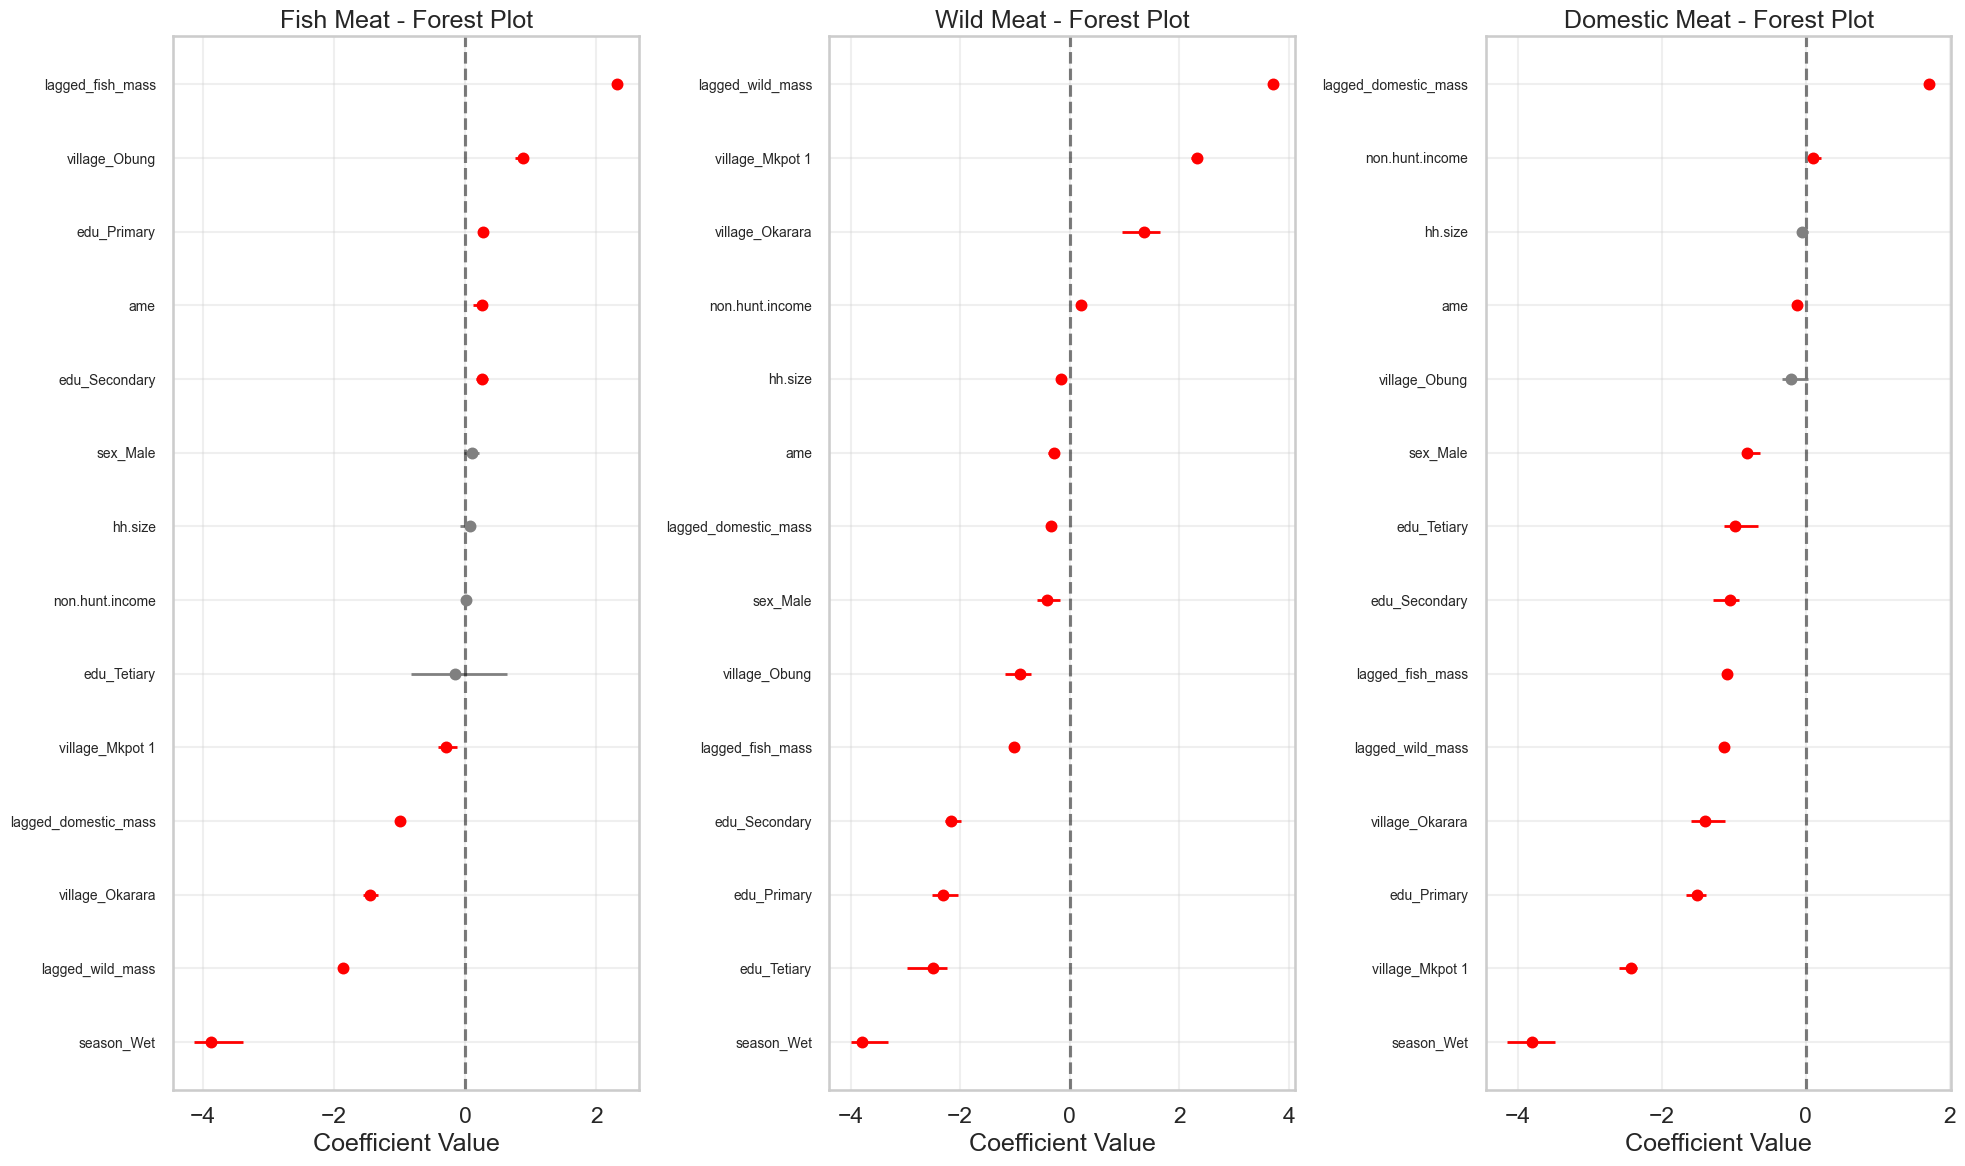

In [34]:
def create_forest_plot():
    beta_summary = az.summary(idata_updated, var_names=['beta'])
    
    # Prepare data for forest plot
    forest_data = []
    for i, row in beta_summary.iterrows():
        var_name = row.name
        if 'beta[' in var_name:
            parts = var_name.replace('beta[', '').replace(']', '').split(', ')
            if len(parts) == 2:
                predictor = parts[0]
                outcome = parts[1]
                
                forest_data.append({
                    'predictor': predictor,
                    'outcome': outcome,
                    'mean': row['mean'],
                    'lower': row['hdi_3%'],
                    'upper': row['hdi_97%'],
                    'significant': (row['hdi_3%'] > 0) or (row['hdi_97%'] < 0)
                })
    
    forest_df = pd.DataFrame(forest_data)
    
    # Create forest plot
    fig, axes = plt.subplots(1, 3, figsize=(20, 12))
    
    for i, meat_type in enumerate(['Fish', 'Wild', 'Domestic']):
        meat_data = forest_df[forest_df['outcome'] == meat_type].copy()
        meat_data = meat_data.sort_values('mean')
        
        # Create forest plot
        y_pos = range(len(meat_data))
        
        # Plot confidence intervals
        for j, (idx, row) in enumerate(meat_data.iterrows()):
            color = 'red' if row['significant'] else 'gray'
            axes[i].hlines(y_pos[j], row['lower'], row['upper'], colors=color, linewidth=2)
            axes[i].scatter(row['mean'], y_pos[j], color=color, s=50, zorder=3)
        
        # Add vertical line at zero
        axes[i].axvline(0, color='black', linestyle='--', alpha=0.5)
        
        # Customize plot
        axes[i].set_yticks(y_pos)
        axes[i].set_yticklabels(meat_data['predictor'], fontsize=10)
        axes[i].set_xlabel('Coefficient Value')
        axes[i].set_title(f'{meat_type} Meat - Forest Plot')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

create_forest_plot()

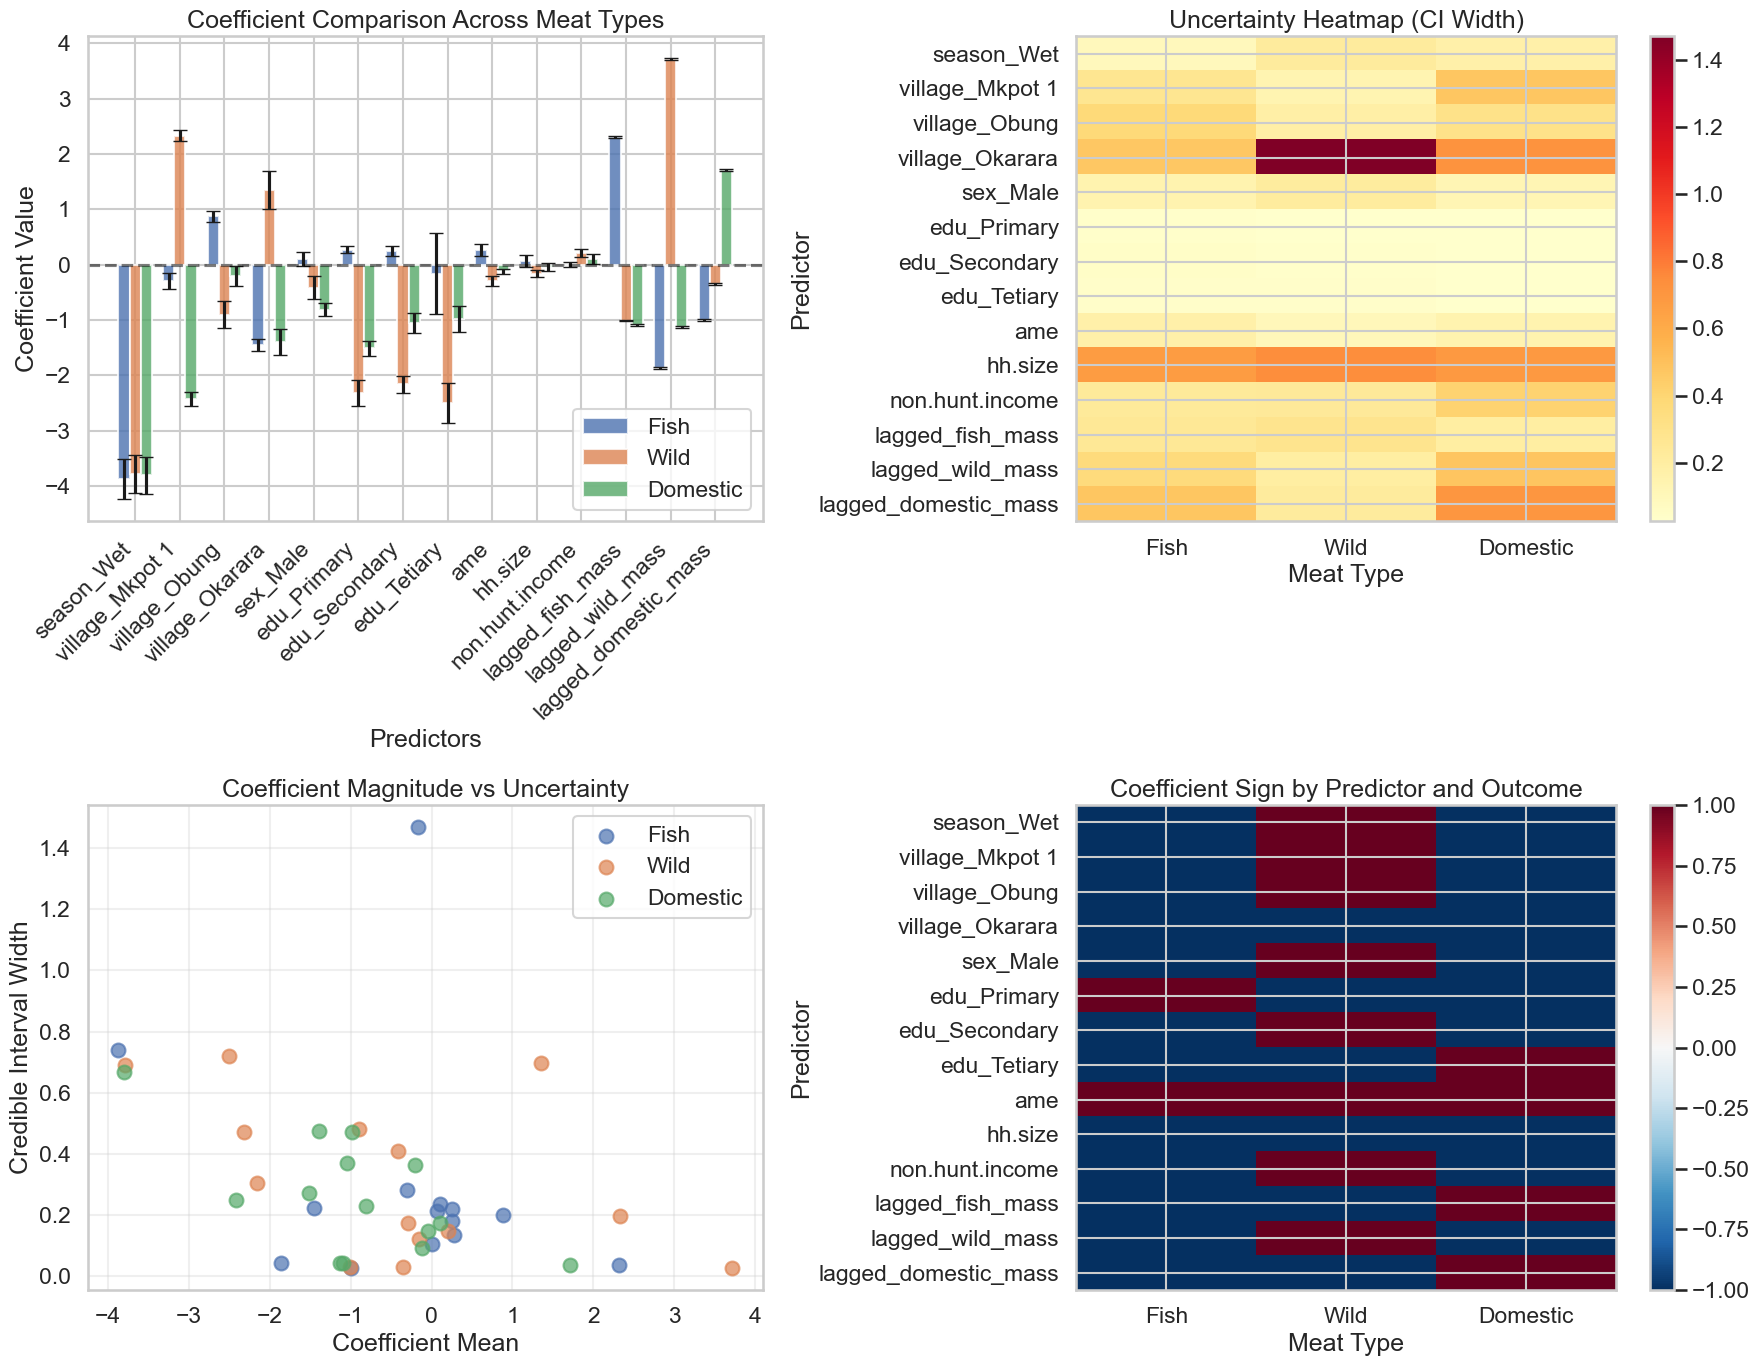

In [35]:
def create_coefficient_comparison():
    beta_summary = az.summary(idata_updated, var_names=['beta'])
    
    # Prepare data
    comparison_data = []
    for i, row in beta_summary.iterrows():
        var_name = row.name
        if 'beta[' in var_name:
            parts = var_name.replace('beta[', '').replace(']', '').split(', ')
            if len(parts) == 2:
                predictor = parts[0]
                outcome = parts[1]
                
                comparison_data.append({
                    'predictor': predictor,
                    'outcome': outcome,
                    'mean': row['mean'],
                    'lower': row['hdi_3%'],
                    'upper': row['hdi_97%'],
                    'ci_width': row['hdi_97%'] - row['hdi_3%']
                })
    
    comp_df = pd.DataFrame(comparison_data)
    
    # Create comparison plot
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Plot 1: Coefficient comparison across meat types
    predictors = comp_df['predictor'].unique()
    x_pos = np.arange(len(predictors))
    width = 0.25
    
    for i, meat_type in enumerate(['Fish', 'Wild', 'Domestic']):
        meat_data = comp_df[comp_df['outcome'] == meat_type]
        means = [meat_data[meat_data['predictor'] == p]['mean'].iloc[0] if len(meat_data[meat_data['predictor'] == p]) > 0 else 0 for p in predictors]
        errors = [meat_data[meat_data['predictor'] == p]['ci_width'].iloc[0]/2 if len(meat_data[meat_data['predictor'] == p]) > 0 else 0 for p in predictors]
        
        axes[0, 0].bar(x_pos + i*width, means, width, yerr=errors, 
                      label=meat_type, alpha=0.8, capsize=5)
    
    axes[0, 0].set_xlabel('Predictors')
    axes[0, 0].set_ylabel('Coefficient Value')
    axes[0, 0].set_title('Coefficient Comparison Across Meat Types')
    axes[0, 0].set_xticks(x_pos + width)
    axes[0, 0].set_xticklabels(predictors, rotation=45, ha='right')
    axes[0, 0].legend()
    axes[0, 0].axhline(0, color='black', linestyle='--', alpha=0.5)
    
    # Plot 2: Uncertainty heatmap
    uncertainty_matrix = comp_df.pivot(index='predictor', columns='outcome', values='ci_width')
    im = axes[0, 1].imshow(uncertainty_matrix, cmap='YlOrRd', aspect='auto')
    axes[0, 1].set_title('Uncertainty Heatmap (CI Width)')
    axes[0, 1].set_xlabel('Meat Type')
    axes[0, 1].set_ylabel('Predictor')
    axes[0, 1].set_xticks(range(len(['Fish', 'Wild', 'Domestic'])))
    axes[0, 1].set_xticklabels(['Fish', 'Wild', 'Domestic'])
    axes[0, 1].set_yticks(range(len(predictors)))
    axes[0, 1].set_yticklabels(predictors)
    plt.colorbar(im, ax=axes[0, 1])
    
    # Plot 3: Coefficient magnitude vs uncertainty
    for i, meat_type in enumerate(['Fish', 'Wild', 'Domestic']):
        meat_data = comp_df[comp_df['outcome'] == meat_type]
        axes[1, 0].scatter(meat_data['mean'], meat_data['ci_width'], 
                          label=meat_type, alpha=0.7, s=100)
    
    axes[1, 0].set_xlabel('Coefficient Mean')
    axes[1, 0].set_ylabel('Credible Interval Width')
    axes[1, 0].set_title('Coefficient Magnitude vs Uncertainty')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Significance by predictor and outcome
    significance_matrix = comp_df.pivot(index='predictor', columns='outcome', 
                                       values='mean').applymap(lambda x: 1 if x > 0 else -1 if x < 0 else 0)
    im = axes[1, 1].imshow(significance_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
    axes[1, 1].set_title('Coefficient Sign by Predictor and Outcome')
    axes[1, 1].set_xlabel('Meat Type')
    axes[1, 1].set_ylabel('Predictor')
    axes[1, 1].set_xticks(range(len(['Fish', 'Wild', 'Domestic'])))
    axes[1, 1].set_xticklabels(['Fish', 'Wild', 'Domestic'])
    axes[1, 1].set_yticks(range(len(predictors)))
    axes[1, 1].set_yticklabels(predictors)
    plt.colorbar(im, ax=axes[1, 1])
    
    plt.tight_layout()
    plt.show()

create_coefficient_comparison()

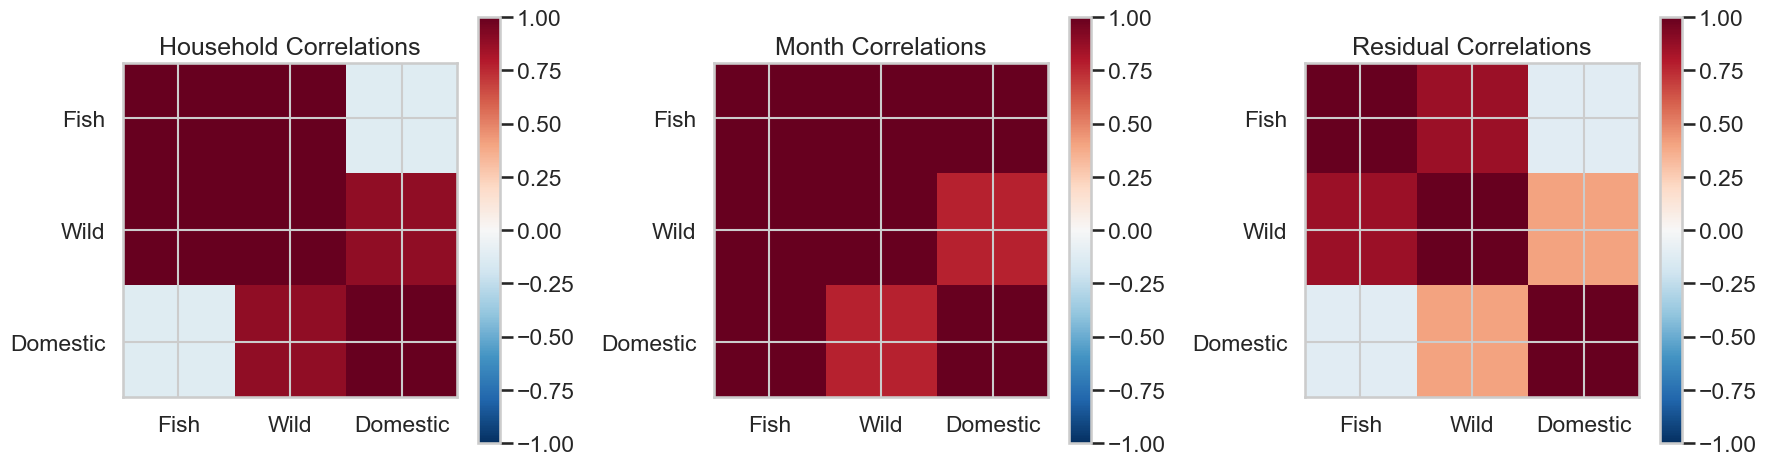

Household Correlations:
[[ 1.          1.11385649 -0.12012172]
 [ 1.11385649  1.          0.88938931]
 [-0.12012172  0.88938931  1.        ]]

Month Correlations:
[[1.         1.6651016  1.42806353]
 [1.6651016  1.         0.76857634]
 [1.42806353 0.76857634 1.        ]]

Residual Correlations:
[[ 1.          0.85679996 -0.1115859 ]
 [ 0.85679996  1.          0.40114278]
 [-0.1115859   0.40114278  1.        ]]


In [52]:
# Analyze interactions between meat types
def analyze_meat_interactions():
    # Extract random effects correlations
    hh_corr = idata_updated.posterior['L_hh']
    month_corr = idata_updated.posterior['L_month']
    eps_corr = idata_updated.posterior['L_eps']
    
    # Create correlation matrices
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Household correlations - reshape to 3x3 matrix
    hh_corr_mean = hh_corr.mean(dim=['chain', 'draw'])
    # Reshape from (6,) to (3, 3) for correlation matrix
    hh_corr_matrix = np.array([[1, hh_corr_mean[0], hh_corr_mean[1]],
                              [hh_corr_mean[0], 1, hh_corr_mean[2]],
                              [hh_corr_mean[1], hh_corr_mean[2], 1]])
    
    im1 = axes[0].imshow(hh_corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
    axes[0].set_title('Household Correlations')
    axes[0].set_xticks([0, 1, 2])
    axes[0].set_yticks([0, 1, 2])
    axes[0].set_xticklabels(['Fish', 'Wild', 'Domestic'])
    axes[0].set_yticklabels(['Fish', 'Wild', 'Domestic'])
    plt.colorbar(im1, ax=axes[0])
    
    # Month correlations - reshape to 3x3 matrix
    month_corr_mean = month_corr.mean(dim=['chain', 'draw'])
    # Reshape from (6,) to (3, 3) for correlation matrix
    month_corr_matrix = np.array([[1, month_corr_mean[0], month_corr_mean[1]],
                                 [month_corr_mean[0], 1, month_corr_mean[2]],
                                 [month_corr_mean[1], month_corr_mean[2], 1]])
    
    im2 = axes[1].imshow(month_corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
    axes[1].set_title('Month Correlations')
    axes[1].set_xticks([0, 1, 2])
    axes[1].set_yticks([0, 1, 2])
    axes[1].set_xticklabels(['Fish', 'Wild', 'Domestic'])
    axes[1].set_yticklabels(['Fish', 'Wild', 'Domestic'])
    plt.colorbar(im2, ax=axes[1])
    
    # Residual correlations - reshape to 3x3 matrix
    eps_corr_mean = eps_corr.mean(dim=['chain', 'draw'])
    # Reshape from (6,) to (3, 3) for correlation matrix
    eps_corr_matrix = np.array([[1, eps_corr_mean[0], eps_corr_mean[1]],
                               [eps_corr_mean[0], 1, eps_corr_mean[2]],
                               [eps_corr_mean[1], eps_corr_mean[2], 1]])
    
    im3 = axes[2].imshow(eps_corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
    axes[2].set_title('Residual Correlations')
    axes[2].set_xticks([0, 1, 2])
    axes[2].set_yticks([0, 1, 2])
    axes[2].set_xticklabels(['Fish', 'Wild', 'Domestic'])
    axes[2].set_yticklabels(['Fish', 'Wild', 'Domestic'])
    plt.colorbar(im3, ax=axes[2])
    
    plt.tight_layout()
    plt.show()
    
    # Print correlation values
    print("Household Correlations:")
    print(hh_corr_matrix)
    print("\nMonth Correlations:")
    print(month_corr_matrix)
    print("\nResidual Correlations:")
    print(eps_corr_matrix)
    
    # Add correlation values as text on the plots
    for i in range(3):
        for j in range(3):
            if i != j:  # Only show off-diagonal values
                axes[0].text(j, i, f'{hh_corr_matrix[i, j]:.3f}', 
                           ha='center', va='center', color='white', fontweight='bold')
                axes[1].text(j, i, f'{month_corr_matrix[i, j]:.3f}', 
                           ha='center', va='center', color='white', fontweight='bold')
                axes[2].text(j, i, f'{eps_corr_matrix[i, j]:.3f}', 
                           ha='center', va='center', color='white', fontweight='bold')

analyze_meat_interactions()

In [40]:
# Create a comprehensive coefficient interpretation guide
def coefficient_interpretation_guide():
    beta_summary = az.summary(idata_updated, var_names=['beta'])
    
    print("🔍 COEFFICIENT INTERPRETATION GUIDE")
    print("="*50)
    
    print("\n1. COEFFICIENT MAGNITUDE:")
    print("   - Larger absolute values = stronger effect")
    print("   - Positive values = increase in consumption")
    print("   - Negative values = decrease in consumption")
    
    print("\n2. CREDIBLE INTERVALS:")
    print("   - HDI_3% to HDI_97% = 94% credible interval")
    print("   - If interval doesn't contain 0 = significant effect")
    print("   - Narrower intervals = more precise estimates")
    
    print("\n3. MEAT TYPE COMPARISONS:")
    print("   - Compare same predictor across meat types")
    print("   - Look for substitution patterns (opposite signs)")
    print("   - Identify complementary patterns (same signs)")
    
    print("\n4. KEY PREDICTORS TO EXAMINE:")
    key_predictors = ['season_Wet', 'village_', 'sex_Male', 'edu_', 'ame', 'hh.size']
    
    for predictor in key_predictors:
        pred_data = beta_summary[beta_summary.index.str.contains(predictor)]
        if len(pred_data) > 0:
            print(f"\n{predictor.upper()}:")
            for idx, row in pred_data.iterrows():
                meat_type = idx.split(', ')[1].replace(']', '')
                effect = "INCREASE" if row['mean'] > 0 else "DECREASE"
                significant = "SIGNIFICANT" if (row['hdi_3%'] > 0) or (row['hdi_97%'] < 0) else "NOT SIGNIFICANT"
                print(f"  {meat_type}: {effect} ({row['mean']:.3f}) - {significant}")

coefficient_interpretation_guide()

🔍 COEFFICIENT INTERPRETATION GUIDE

1. COEFFICIENT MAGNITUDE:
   - Larger absolute values = stronger effect
   - Positive values = increase in consumption
   - Negative values = decrease in consumption

2. CREDIBLE INTERVALS:
   - HDI_3% to HDI_97% = 94% credible interval
   - If interval doesn't contain 0 = significant effect
   - Narrower intervals = more precise estimates

3. MEAT TYPE COMPARISONS:
   - Compare same predictor across meat types
   - Look for substitution patterns (opposite signs)
   - Identify complementary patterns (same signs)

4. KEY PREDICTORS TO EXAMINE:

SEASON_WET:
  Fish: DECREASE (-3.870) - SIGNIFICANT
  Wild: DECREASE (-3.786) - SIGNIFICANT
  Domestic: DECREASE (-3.806) - SIGNIFICANT

VILLAGE_:
  Fish: DECREASE (-0.298) - SIGNIFICANT
  Wild: INCREASE (2.329) - SIGNIFICANT
  Domestic: DECREASE (-2.420) - SIGNIFICANT
  Fish: INCREASE (0.879) - SIGNIFICANT
  Wild: DECREASE (-0.900) - SIGNIFICANT
  Domestic: DECREASE (-0.207) - NOT SIGNIFICANT
  Fish: DECREASE 

In [26]:
# Model comparison and diagnostics
print("\n📈 Model Performance:")
print(f"Number of observations: {n_obs}")
print(f"Number of parameters: {len(feature_names) * 3 + n_households * 3 + n_months * 3 + 9}  # Fixed + Random + Covariance")

# Check effective sample size for specific variables only (to avoid memory issues)
print("\n🔍 Effective Sample Size (ESS) for key parameters:")
try:
    # Calculate ESS for beta coefficients only
    ess_beta = az.ess(idata_updated, var_names=['beta'])
    print(f"ESS for beta coefficients: {ess_beta['beta'].min().values:.0f}")
    
    # Calculate ESS for covariance matrices
    ess_cov = az.ess(idata_updated, var_names=['L_hh', 'L_month', 'L_eps'])
    print(f"ESS for covariance matrices: {ess_cov.to_array().min().values:.0f}")
    
except MemoryError:
    print("⚠️ Memory limit reached for ESS calculation")
    print("Model is too large for full ESS computation")

# Log-likelihood
log_lik = idata_updated.log_likelihood['y']
print(f"Log-likelihood: {log_lik.mean().values:.2f}")


📈 Model Performance:
Number of observations: 7828
Number of parameters: 351  # Fixed + Random + Covariance

🔍 Effective Sample Size (ESS) for key parameters:
ESS for beta coefficients: 2
ESS for covariance matrices: 3
Log-likelihood: -18.89


📊 MODEL PERFORMANCE METRICS


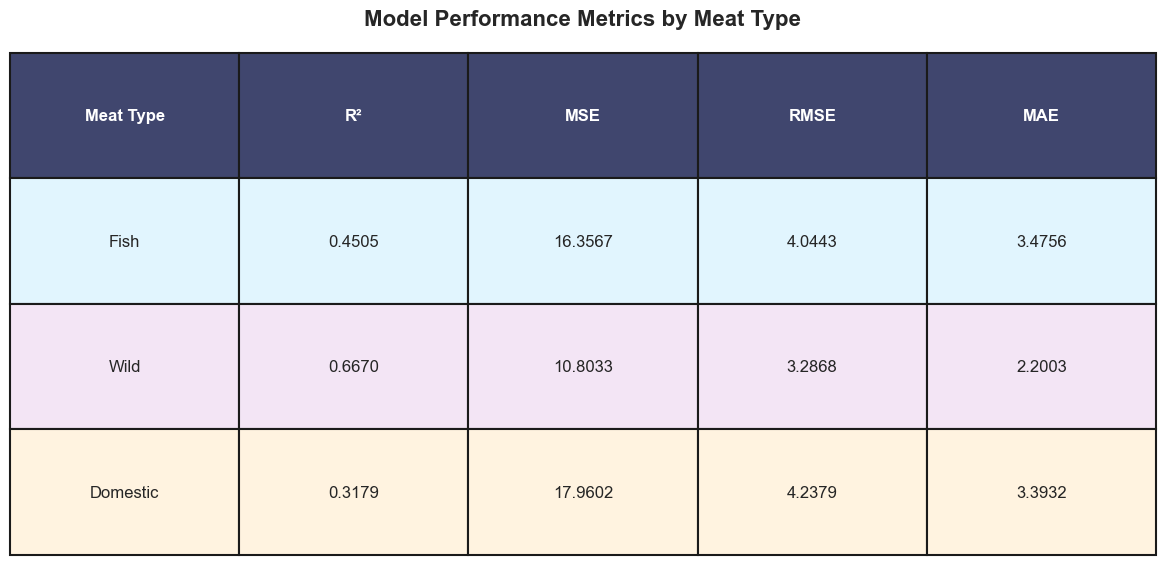


📈 PERFORMANCE SUMMARY:
Fish: R² = 0.4505 (Fair)
Wild: R² = 0.6670 (Good)
Domestic: R² = 0.3179 (Fair)

Overall Model R²: 0.4785

🔍 INTERPRETATION:
• R² values range from 0 to 1, where 1 = perfect fit
• Values > 0.7 indicate excellent model performance
• Values 0.5-0.7 indicate good model performance
• Values 0.3-0.5 indicate fair model performance
• Values < 0.3 indicate poor model performance


In [55]:
# Calculate predicted R² for the three meat categories
def calculate_predicted_r2():
    # Get the model predictions (mu) and take mean across chains and draws
    predictions = idata_updated.posterior['mu'].mean(dim=['chain', 'draw'])  # Mean predictions
    
    # Get observed data from the original dataset
    observed_data = Y_log  # This is the log-transformed observed data used in the model
    
    # Calculate R² for each meat type
    r2_results = {}
    
    for i, meat_type in enumerate(['Fish', 'Wild', 'Domestic']):
        # Extract data for this meat type
        pred_meat = predictions[:, i].values  # Mean predictions for this meat type
        obs_meat = observed_data[:, i]  # Observed data for this meat type
        
        # Calculate R²
        # R² = 1 - (SS_res / SS_tot)
        # SS_res = sum of squared residuals
        # SS_tot = total sum of squares
        
        ss_res = np.sum((obs_meat - pred_meat) ** 2)
        ss_tot = np.sum((obs_meat - np.mean(obs_meat)) ** 2)
        
        r2 = 1 - (ss_res / ss_tot)
        
        # Calculate additional metrics
        mse = np.mean((obs_meat - pred_meat) ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(obs_meat - pred_meat))
        
        r2_results[meat_type] = {
            'R2': r2,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae
        }
    
    return r2_results

# Calculate and display R² results
r2_results = calculate_predicted_r2()

print("📊 MODEL PERFORMANCE METRICS")
print("="*60)

# Create a formatted table
performance_data = []
for meat_type, metrics in r2_results.items():
    performance_data.append({
        'Meat Type': meat_type,
        'R²': f"{metrics['R2']:.4f}",
        'MSE': f"{metrics['MSE']:.4f}",
        'RMSE': f"{metrics['RMSE']:.4f}",
        'MAE': f"{metrics['MAE']:.4f}"
    })

performance_df = pd.DataFrame(performance_data)

# Display as a formatted table
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=performance_df.values,
                colLabels=performance_df.columns,
                cellLoc='center',
                loc='center',
                bbox=[0, 0, 1, 1])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)

# Color code the header
for i in range(len(performance_df.columns)):
    table[(0, i)].set_facecolor('#40466e')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Color code rows by meat type
colors = {'Fish': '#e1f5fe', 'Wild': '#f3e5f5', 'Domestic': '#fff3e0'}
for i in range(1, len(performance_df) + 1):
    meat_type = performance_df.iloc[i-1]['Meat Type']
    color = colors.get(meat_type, 'white')
    for j in range(len(performance_df.columns)):
        table[(i, j)].set_facecolor(color)

plt.title('Model Performance Metrics by Meat Type', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Print summary
print("\n📈 PERFORMANCE SUMMARY:")
for meat_type, metrics in r2_results.items():
    r2 = metrics['R2']
    if r2 > 0.7:
        performance = "Excellent"
    elif r2 > 0.5:
        performance = "Good"
    elif r2 > 0.3:
        performance = "Fair"
    else:
        performance = "Poor"
    
    print(f"{meat_type}: R² = {r2:.4f} ({performance})")

# Calculate overall model performance
overall_r2 = np.mean([metrics['R2'] for metrics in r2_results.values()])
print(f"\nOverall Model R²: {overall_r2:.4f}")

# Interpretation
print(f"\n🔍 INTERPRETATION:")
print(f"• R² values range from 0 to 1, where 1 = perfect fit")
print(f"• Values > 0.7 indicate excellent model performance")
print(f"• Values 0.5-0.7 indicate good model performance")
print(f"• Values 0.3-0.5 indicate fair model performance")
print(f"• Values < 0.3 indicate poor model performance")